# Work Sample: Predictive Maintenance

### Author: Leopoldo Carbajal (leo.carbajalg@gmail.com)

## EC2 instance description:

Jupyter Notebook run on Anaconda environment with Python 3 on a c5.4xlarge EC2 instance.

In [1]:
import platform
import multiprocessing

print("Platform description:")
print(platform.uname(), "\n")
print("Number of cores used in parallel computations: ", multiprocessing.cpu_count())

Platform description:
uname_result(system='Linux', node='ip-172-31-14-145', release='4.14.171-105.231.amzn1.x86_64', version='#1 SMP Thu Feb 27 23:49:15 UTC 2020', machine='x86_64', processor='x86_64') 

Number of cores used in parallel computations:  16


## Sumary:

A machine learning (ML) model for predictive maintenance [**with an accuracy of up to 88% for predicting device failure**](#best_model) has been developed using historical telemetry data of a fleet of devices of **COMPANY XYZ**. **Sub-sampling methods together with feature selection and fine-tuning of model parameters give the best model with higher accuracy for predicting both device failure and non-failure**.

First, a [detailed analysis](#data_analysis) of the raw data is presented. It is found that the data is imbalanced, meaning that there are fewer data about failing devices than non-failing devices.

Then, a section where the data is [cleaned and transformed](#data_transformation) to be used in a machine learning algorithm, that is, the data is split in training and test subsets.

A whole section is devoted to [implement and test different ML algorithms](#ML_algorithms), all based on a Random Forest Classifier (RFC). Different [metrics for measuring their performance](#metrics) are implemented and explained. It is found that [RFCs using under-sampling methods for data balancing](#balanced_RFC) show superior performance, increasing accuracy in predicting device failure. Two more strategies are used to further improve RFCs performance, namely:

1. [Feature selection](#feature_selection)
2. [Hyperparameter optimization](#random_search_CV)

A [comparison between the above ML algorithms](#comparison) is presented, and the best performing model identified.

Finally, all the above is put together to perform a [cross-validation analysis to find the best RFC](#best_model) with the higher accuracy in failure prediction for a given forecast period.

## Implementation:

A detailed explanation on the implementation of the predictive maintenance model is presented in the cells below. Python functions used along the entire notebook are implemented as they are being needed.

First, in the cell below we load all the python libraries that will be used in the notebook.

In [2]:
# PYTHON LIBRARIES
# Standard libraries
import numpy as np
import pandas as pd
from pandas.api.types import CategoricalDtype
import time as t
from datetime import datetime
from datetime import timezone
from IPython.display import HTML, display, Image
from tqdm.notebook import tqdm

# Scikit-learn
import sklearn as sk
from sklearn import tree 
from sklearn.ensemble import RandomForestClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.feature_selection import chi2
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics import precision_recall_curve, roc_curve, confusion_matrix, plot_confusion_matrix
from sklearn.metrics import recall_score, roc_auc_score, balanced_accuracy_score

# Matplotlib
import matplotlib as mplt
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline

print("CONFIGURATION:")
print("Numpy version:", np.__version__)
print("Pandas version:", pd.__version__)
print("Matplotlib version:", mplt.__version__)
print("Scikit-learn version:", sk.__version__)

pd.set_option('max_columns',500)
pd.set_option('max_rows',500)

CONFIGURATION:
Numpy version: 1.18.1
Pandas version: 1.0.3
Matplotlib version: 3.1.3
Scikit-learn version: 0.22.1


---
## Metadata

A useful way of keeping important information about how the predictive model is implemented is through the use of a python dictionary that keeps important information. This, can later be used to summarize how we proceeded during model implementation and during debugging. We call this dictionary `metadata`. In the cell below is created and in the following cells information is added as needed.

In [3]:
metadata = dict()

---
## Data Loading

We load the telemetry data from the original csv file to a [Pandas DataFrame](https://pandas.pydata.org/) named `raw_data` using the `read_csv` function. The appropriate enconding scheme is used to load the data.

In [4]:
metadata['file_name'] = "data.csv"

raw_data = pd.read_csv(metadata['file_name'], encoding = "ISO-8859-1")

metadata['number_of_records'] = raw_data.shape[0]

display( HTML( raw_data.head(5).to_html() ) )

print("Number of records in dataset: ", metadata['number_of_records'])

,date,device,failure,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute8,attribute9
0,2015-01-01,S1F01085,0,215630672,56,0,52,6,407438,0,0,7
1,2015-01-01,S1F0166B,0,61370680,0,3,0,6,403174,0,0,0
2,2015-01-01,S1F01E6Y,0,173295968,0,0,0,12,237394,0,0,0
3,2015-01-01,S1F01JE0,0,79694024,0,0,0,6,410186,0,0,0
4,2015-01-01,S1F01R2B,0,135970480,0,0,0,15,313173,0,0,3


Number of records in dataset:  124494


<a id='data_analysis'></a>

---
## Data analysis

Now, we perform an analysis of the raw telemetry data. From the cell above, we confirm that the dataset is made of 12 columns:

1. date: the date the telemetry data is obtained.
2. device: ID of each device
3. failure: integer flag for indicating device failure (1) or non-failure (0)  
4. attribute1 to attribute9: telemetry values

In the cell below, a quick search for NULLS is performed:

In [5]:
# We keep the number of attributed in the metadata
metadata['num_attributes'] = 9

# Brief analysis of NULLs
raw_data.isnull().sum(axis=0)

date          0
device        0
failure       0
attribute1    0
attribute2    0
attribute3    0
attribute4    0
attribute5    0
attribute6    0
attribute7    0
attribute8    0
attribute9    0
dtype: int64

**No nulls are found in the original dataset**.

Then, we identify which devices have failed and those working normally:

In [6]:
# we keep a list with the IDs of the failing devices for further analysis
failing_devices = raw_data[raw_data['failure'] == 1]['device'].unique().tolist()
working_devices = raw_data[~raw_data['device'].isin(failing_devices)]['device'].unique().tolist()

# Number of different devices
metadata['devices'] = raw_data['device'].unique()
metadata['number_of_devices'] = len(metadata['devices'])

print("Number of devices: ", metadata['number_of_devices'])
print("Number of failing devices in dataset: %4d (%3.2f%% of total devices)" % (len(failing_devices), 100.0*len(failing_devices)/metadata['number_of_devices']))
print("Number of working devices in dataset: %4d (%3.2f%% of total devices)" % (len(working_devices), 100.0*len(working_devices)/metadata['number_of_devices']))

Number of devices:  1169
Number of failing devices in dataset:  106 (9.07% of total devices)
Number of working devices in dataset: 1063 (90.93% of total devices)


The above analysis tells us about an **imbalanced dataset**, also known as **class imbalance problem**, containing approximately 90% of non-failing devices, and only about 9% of failing devices. This needs to be taken into account when implementing the ML algorithms.

For easier use of the data, we set the device ID as the indices of `raw_data`:

In [7]:
# We use the device ID as the new index of the dataframe for simplicity
raw_data.set_index(keys='device', 
                   drop=True,
                   inplace=True,
                   verify_integrity=False
                  )

display( HTML( raw_data.head(5).to_html() ) )

,date,failure,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute8,attribute9
device,,,,,,,,,,,
S1F01085,2015-01-01,0,215630672,56,0,52,6,407438,0,0,7
S1F0166B,2015-01-01,0,61370680,0,3,0,6,403174,0,0,0
S1F01E6Y,2015-01-01,0,173295968,0,0,0,12,237394,0,0,0
S1F01JE0,2015-01-01,0,79694024,0,0,0,6,410186,0,0,0
S1F01R2B,2015-01-01,0,135970480,0,0,0,15,313173,0,0,3


Next, we check for missing days of telemetry data. For this, we cast the date to numpy `datetime64` type:

In [8]:
raw_data['DATE'] = pd.to_datetime(arg=raw_data['date'],
                                  yearfirst=True,
                                  errors='coerce'
                                 )
raw_data.drop(labels='date',
              axis=1,
              inplace=True
             )
                                  
display( HTML( raw_data.sample(5).to_html() ) )

,failure,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute8,attribute9,DATE
device,,,,,,,,,,,
S1F11G2C,0,14858840,0,0,0,16,344477,0,0,0,2015-05-06
S1F12ZRR,0,196146304,0,0,0,8,257626,0,0,0,2015-06-13
Z1F14BGY,0,227785872,0,0,0,8,204434,0,0,0,2015-05-07
S1F0S387,0,148241408,0,2,0,12,270771,0,0,34,2015-02-21
S1F136FG,0,26898280,0,0,0,12,240448,0,0,0,2015-01-31


In the cell below we calculate the days of telemetry data of each device in the original dataset, and find out whether there are missing days of data or not. For this, we find the newest (`NEWEST_DATE`) and oldest (`OLDEST_DATE`) date in the dataset for each device. Using these dates, we calculate the days in that period of time (`DAYS_IN_PERIOD`) and compare it against the actual days of telemetry data for a given device (`DAYS_OF_DATA`). If for a given device `DAYS_OF_DATA` is less than `DAYS_IN_PERIOD`, then there are missing days of data for that device `MISSING_DAYS = True`, otherwise `MISSING_DAYS = False`.

The information of this analysis is kept in a DataFrame named `data_analysis`, which is used throughout the notebook.

In [9]:
# We check whether there are missing days of data or not
columns_data_analysis = ['FAILURE',
                         'NEWEST_DATE',
                         'OLDEST_DATE',
                         'DAYS_OF_DATA',
                         'DAYS_IN_PERIOD',
                         'MISSING_DAYS'
                        ]

data_analysis = pd.DataFrame(data=None, columns=columns_data_analysis)

devices = working_devices + failing_devices
tqdm_devices = tqdm(devices)
tqdm_devices.set_description("Devices analysed")

for dev in tqdm_devices:
    df_ = raw_data.loc[dev]
    if isinstance(df_,pd.DataFrame):
        failure = df_['failure'].sum()
        newest_date = df_['DATE'].max()
        oldest_date = df_['DATE'].min()
        days_of_data = df_.shape[0]
        days_in_period = ( (newest_date.to_period('D') + 1) - oldest_date.to_period('D') ).delta.days
        missing_days = True if (days_of_data != days_in_period) else False
    else:
        failure = bool(df_['failure'])
        newest_date = np.nan
        oldest_date = np.nan
        days_of_data = 1
        days_in_period = 1
        missing_days = False
    
    data_analysis.loc[dev,:] = [failure, newest_date, oldest_date, days_of_data, days_in_period, missing_days]

working_devices_missing_days = data_analysis[data_analysis['FAILURE'] == False]['MISSING_DAYS'].sum()
failing_devices_missing_days = data_analysis[data_analysis['FAILURE'] == True]['MISSING_DAYS'].sum()

print("Number of working devices with missing days of data: %5d" % (working_devices_missing_days))
print("Number of working devices with missing days of data: %5d" % (failing_devices_missing_days))    

display( HTML( data_analysis.head(5).to_html() ) )


Number of working devices with missing days of data:   158
Number of working devices with missing days of data:    15


,FAILURE,NEWEST_DATE,OLDEST_DATE,DAYS_OF_DATA,DAYS_IN_PERIOD,MISSING_DAYS
S1F01085,0,2015-01-06 00:00:00,2015-01-01 00:00:00,6,6,False
S1F0166B,0,2015-01-06 00:00:00,2015-01-01 00:00:00,6,6,False
S1F01E6Y,0,2015-02-17 00:00:00,2015-01-01 00:00:00,48,48,False
S1F01JE0,0,2015-01-06 00:00:00,2015-01-01 00:00:00,6,6,False
S1F01R2B,0,2015-08-24 00:00:00,2015-01-01 00:00:00,223,236,True


Devices with missing days of telemetry data are dropped and a new DataFrame named `df_raw_data` is created with telemetry data of devices with only consecutive days of data.

In [10]:
# For cleaning the dataset, we drop records of devices missing 
# consecutive days of data

devices_to_drop = data_analysis[data_analysis['MISSING_DAYS'] == True].index.to_list()

data_analysis.drop(index=devices_to_drop,
                   inplace=True
                  )

# We create a new DataFrame with devices with only consecutive
# days of data
df_raw_data = raw_data.copy(deep=True)

df_raw_data.drop(index=devices_to_drop,
                 inplace=True
                )

# Brief description of clean dataset
number_devices = len(data_analysis.index)
number_failing_devices = len(data_analysis[data_analysis['FAILURE'] == True].index)
number_working_devices = len(data_analysis[data_analysis['FAILURE'] == False].index)

print("Number of devices: ", number_devices)
print("Number of failing devices in dataset: %3.2f%%" % (100.0*number_failing_devices/number_devices))
print("Number of working devices in dataset: %3.2f%%" % (100.0*number_working_devices/number_devices))

display( HTML( df_raw_data.head(5).to_html() ) )

Number of devices:  996
Number of failing devices in dataset: 9.14%
Number of working devices in dataset: 90.86%


,failure,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute8,attribute9,DATE
device,,,,,,,,,,,
S1F01085,0,215630672,56,0,52,6,407438,0,0,7,2015-01-01
S1F0166B,0,61370680,0,3,0,6,403174,0,0,0,2015-01-01
S1F01E6Y,0,173295968,0,0,0,12,237394,0,0,0,2015-01-01
S1F01JE0,0,79694024,0,0,0,6,410186,0,0,0,2015-01-01
S1F01TD5,0,68837488,0,0,41,6,413535,0,0,1,2015-01-01


At this point we already have a clean dataset, and based on further analysis we can decide how to formulate a model for predictive maintenance. To date, two approaches are broadly used for generating predictive maintenance models:

1. [Remaining useful life estimation (RUL)](https://link.springer.com/article/10.1007/s13198-013-0195-0), which tells us when a given device is likely to fail
2. [Classification approach](https://en.wikipedia.org/wiki/Statistical_classification), which tells us whether in a fixed number of days (days of prediction) a given device is likely to fail or not.

A model based on RUL would require enough telemetry data of devices failing after a given number of days, with no gaps in data between day 1 to the day failure occurs. 

**From the histogram below, we observe that we have a lot of gaps of between days of data, from day 1 to the day when failure occurs. Therefore, we opt to generate a predictive model using a classification approach**.

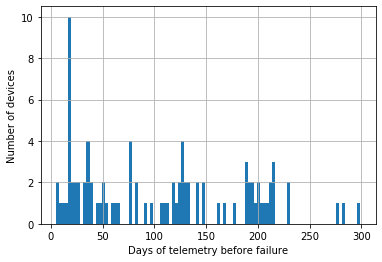

In [11]:
data_analysis[data_analysis['FAILURE'] == 1]['DAYS_OF_DATA'].hist(bins=100)
plt.ylabel("Number of devices")
plt.xlabel("Days of telemetry before failure")

plt.show()

<a id='data_transformation'></a>

---
## Data Transformation

Now that we have decided to use a **classification approach** for our predictive maintenance ML model, we start by defining the number of days of historical telemetry data (`days_of_training_data`) that our model will use to train and the number of days of prediction (`days_of_prediction`), a total of `total_days_of_data = days_of_training_data + days_of_prediction` days of data per device. In the figure below we show an example of how days of telemetry data of a failing device are chosen for generating the dataset that will feed the ML model.

![title](images/choosing_days_of_data.png)

For non-failing devices we choose the total days of required data in a similar way, selecting the days data from the newest date of data backwards.

For our first set of ML models we choose `days_of_training_data = 14` and `days_of_prediction = 5`. 

In [12]:
metadata['days_of_training_data'] = 14

metadata['days_of_prediction'] = 5

# Total days of data of each device for generating predictive model
metadata['total_days_of_data'] = metadata['days_of_training_data'] + metadata['days_of_prediction']

The python function below selects the days of data for training the ML models and generate a new DataFrame with the data, with rows representing the telemetry data of different devices.

In [13]:
def generate_model_dataset(df, df_analysis, metadata):
    # We choose devices with days of data equal or larger than 
    devices_to_use = df_analysis[df_analysis['DAYS_OF_DATA'] >= metadata['total_days_of_data']].index
    
    # We rename columns for easier use
    new_names = dict()
    for ii in range(1,10):
        new_names['attribute' + str(ii)] = "A" + str(ii)

    new_names['failure'] = 'FAILURE'   
    
    # DataFrame with only selected devices
    data = df.loc[devices_to_use]

    data.rename(columns=new_names,
                inplace=True
               )

    data.index.rename(name='DEVICE',
                  inplace=True
                 )
    
    # A brief description of the dataset to be used
    df_ = data_analysis.loc[devices_to_use].copy(deep=True)

    number_devices = len(df_.loc[devices_to_use].index)
    number_failing_devices = len(df_[df_['FAILURE'] == True].index)
    number_working_devices = len(df_[df_['FAILURE'] == False].index)

    print("DATA PREPARATION: ")
    print("Number of devices to be used: ", number_devices)
    print("Number of failing devices in dataset: %3.2f%%" % (100.0*number_failing_devices/number_devices))
    print("Number of working devices in dataset: %3.2f%%" % (100.0*number_working_devices/number_devices))
    
    # Columns' name of final DataFrame
    columns = ['FAILURE']
    for ii in range(1,metadata['num_attributes']+1):
        for jj in range(1,metadata['days_of_training_data']+1):
            columns.append("A" + str(ii) + "_D" + str(jj))
            
    # DataFrame with data to be used to train predictive models
    df_model = pd.DataFrame(data=None, columns=columns)
    
    tqdm_devices = tqdm(data.index.unique())
    tqdm_devices.set_description("Devices processed")

    for dev in tqdm_devices:
        df_ = data.loc[dev].set_index(keys='DATE', 
                                      drop=True,
                                      inplace=False,
                                      verify_integrity=False
                                     ).sort_index(axis='index', 
                                                  ascending=False,
                                                  inplace=False
                                                 )
        FAILURE = df_['FAILURE'].any()

        df_ = df_.iloc[metadata['days_of_prediction']:metadata['total_days_of_data']].astype(dtype=int)

        data_ = [FAILURE]
        for ii in range(1, metadata['num_attributes']+1):
            data_ = data_ + df_['A'+str(ii)].values.tolist()

        df_model.loc[dev] = data_


    df_model = df_model.astype(dtype=int)
    
    
    return df_model

We now generate the data for the ML models, the resulting DataFrame with the transformed data of each device is kept in a DataFrame named `df_model`. A sample of this DataFrame is shown below. 

The rows of `df_model` have the telemetry data of each device. The column `FAILURE` is the target binary variable. The other columns contain the attribute values of the devices for each day of data to be used. For example, column `A1_D5` refers to the value of `attribute1` on day 5 in the historical data to be used.

In [14]:
df_model = generate_model_dataset(df=df_raw_data,
                                  df_analysis=data_analysis,
                                  metadata=metadata
                                 )

display( HTML( df_model.sample(5).to_html() ) )

DATA PREPARATION: 
Number of devices to be used:  609
Number of failing devices in dataset: 13.79%
Number of working devices in dataset: 86.21%


,FAILURE,A1_D1,A1_D2,A1_D3,A1_D4,A1_D5,A1_D6,A1_D7,A1_D8,A1_D9,A1_D10,A1_D11,A1_D12,A1_D13,A1_D14,A2_D1,A2_D2,A2_D3,A2_D4,A2_D5,A2_D6,A2_D7,A2_D8,A2_D9,A2_D10,A2_D11,A2_D12,A2_D13,A2_D14,A3_D1,A3_D2,A3_D3,A3_D4,A3_D5,A3_D6,A3_D7,A3_D8,A3_D9,A3_D10,A3_D11,A3_D12,A3_D13,A3_D14,A4_D1,A4_D2,A4_D3,A4_D4,A4_D5,A4_D6,A4_D7,A4_D8,A4_D9,A4_D10,A4_D11,A4_D12,A4_D13,A4_D14,A5_D1,A5_D2,A5_D3,A5_D4,A5_D5,A5_D6,A5_D7,A5_D8,A5_D9,A5_D10,A5_D11,A5_D12,A5_D13,A5_D14,A6_D1,A6_D2,A6_D3,A6_D4,A6_D5,A6_D6,A6_D7,A6_D8,A6_D9,A6_D10,A6_D11,A6_D12,A6_D13,A6_D14,A7_D1,A7_D2,A7_D3,A7_D4,A7_D5,A7_D6,A7_D7,A7_D8,A7_D9,A7_D10,A7_D11,A7_D12,A7_D13,A7_D14,A8_D1,A8_D2,A8_D3,A8_D4,A8_D5,A8_D6,A8_D7,A8_D8,A8_D9,A8_D10,A8_D11,A8_D12,A8_D13,A8_D14,A9_D1,A9_D2,A9_D3,A9_D4,A9_D5,A9_D6,A9_D7,A9_D8,A9_D9,A9_D10,A9_D11,A9_D12,A9_D13,A9_D14
S1F0S387,0,160052360,60075552,130697208,68407312,49924448,31706520,14574048,238722448,221270440,80226536,210564208,190188512,94191720,58342168,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,2,2,2,2,2,2,2,2,2,2,2,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,13,13,13,13,13,13,13,13,13,13,13,13,13,13,302267,302267,302267,301318,300105,298942,297777,296513,295210,294025,294025,294024,293983,293983,8,8,8,8,8,8,8,8,8,8,8,0,0,0,8,8,8,8,8,8,8,8,8,8,8,0,0,0,34,34,34,34,34,34,34,34,34,34,34,34,34,34
Z1F0LT0S,0,236557240,136198352,170016776,233819784,23183256,163211248,183662312,58512048,99343208,233301880,75640920,76298312,172708560,12746816,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,7,7,7,7,7,7,7,7,7,7,7,7,7,7,340121,340121,340072,340072,340072,340072,340072,340072,340072,340065,340063,340062,340061,340055,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
S1F0S3DF,0,14156624,74655888,147007016,212540544,50311168,164628216,15307560,95332640,206475888,54371280,154076000,25690784,130156832,17199464,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8,8,8,8,8,8,8,8,8,8,8,8,8,8,190882,190882,190882,190882,190882,190882,190882,190882,190882,190882,190882,190882,190882,190882,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,2,2,2,2,2,2,2,2,2,2,2,2
S1F10GSG,0,22953832,70619168,78725224,41521576,35945336,231009480,237286416,231116880,128129768,89012192,93566152,33976392,13743696,48131176,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,9,9,9,9,9,9,9,9,9,9,9,9,9,9,251646,251646,251596,251591,251591,251591,251591,251591,251591,251591,251585,251585,251584,251583,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
S1F114QM,0,83290936,222104048,158155152,103898696,198581832,64704400,45099416,28510472,86683656,239950344,196461560,39674824,193159464,77635840,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,9,9,9,9,9,9,9,9,9,9,9,9,9,9,427334,427334,427334,427301,427293,426671,425313,423927,423218,423215,423214,423214,423214,423214,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


<a id='data_split'></a>

## Data Split for Training and Testing

Now, we define the training and testing subsets of data. As a convention throughout the notebook, we will split the data of `df_model` in 70% for training data, and 30% for testing data. The resulting DataFrames with train data will be `X_train` and `Y_train`, with the former containing the attribute values (features) and the latter containing the target variable (0 or 1 for non-failure and failure, respectively). Similarly, test data will be kept in `X_test` and `Y_test`.

In [15]:
metadata['test_size'] = 0.3

The python function in the cell below splits the data in train and test subsets.

In [16]:
def split_data(metadata, df):
    columns = df.columns

    metadata['target'] = 'FAILURE'
    metadata['features'] = columns[~columns.isin( [metadata['target']] )]

    # We'll call X the DataFrame with the features data, and Y the corresponding DataFrame of targets

    # Features
    X_model = df[metadata['features']].copy(deep=True).astype(dtype=int)

    # Target
    Y_model = df[metadata['target']].copy(deep=True).astype(dtype=int)

    X_train, X_test, Y_train, Y_test = train_test_split(X_model, Y_model,
                                                        test_size=metadata['test_size'],
                                                        random_state=0
                                                       )

    print("DATA SPLITTING: ")
    print("Rows (devices) in dataset: ", len(X_model.index))
    print("Rows (devices) in train subset: ", len(X_train.index))
    print("Rows (devices) in test subset: ", len(X_test.index))
    
    return X_train, X_test, Y_train, Y_test

In [17]:
X_train, X_test, Y_train, Y_test = split_data(metadata, df_model)

DATA SPLITTING: 
Rows (devices) in dataset:  609
Rows (devices) in train subset:  426
Rows (devices) in test subset:  183


<a id='ML_algorithms'></a>

---
## Machine Learning Algorithms: Random Forest Classifiers

In this section, we implement **ML modes based on Random Forest Classifiers (RFCs)** for predicting device failure. We use [scikit-learn](https://scikit-learn.org/stable/) together with the [imbalanced-learn](https://imbalanced-learn.readthedocs.io/en/stable/) python library to generate different types of RFCs. Scikit-learn provides an easy way to implement a RFC with its class `RandomForestClassifier`, while imbalanced-learn extends its capabilities by providing [under-sampling algorithms](https://imbalanced-learn.readthedocs.io/en/stable/under_sampling.html?highlight=feature%20selection) that mitigate the effect of class imbalance in our dataset. 

These under-sampling algorithms are integrated in the pipelines for training Scikit-learn's `RandomForestClassifier` and are exposed with the class `BalancedRandomForestClassifier` that has all the original functionalities and parameters than `RandomForestClassifier`.

We implement both models `RandomForestClassifier` and `BalancedRandomForestClassifier`, and after finding the model with better accuracy (to be defined below) we include further optimizations through two methods:

1. Feature selection: only data with some kind of correlation is used to train the RFC.
2. Hyperparameter optimization: RFC's parameters are choosen through a cross-validation analysis.

After testing both models, with and without further optimizations, **we choose the RFC with better accuracy to predict device failure as the predictive maintenance algorithm for COMPANY XYZ**.

Before going through the implementation of the above models, we will define how accuracy will be measured.

<a id='metrics'></a>

---
## Performance Metrics: Definition of Accuracy

The cell below contains the python function `assess_quality`, which computes the following performance scores and diagnostics of our RFCs:

* [Standard accuracy](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html#sklearn.metrics.accuracy_score) (`STANDARD_ACCURACY`): measures the fraction of correct predictions.
* [ROC curve](https://scikit-learn.org/stable/modules/model_evaluation.html#roc-metrics): the false positive rate (`FPR`) and true positive rate (`TPR`) are used to plot this curve.
* [Area under ROC curve](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html#sklearn.metrics.roc_auc_score) (`ROC_AUC`): summarizes ROC curve.
* [Precision-Recall curve](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_curve.html): precision (`PRECISION`) and recall (`RECALL`) are used to plot this curve.
* [Average precision](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.average_precision_score.html#sklearn.metrics.average_precision_score) (`AP`): summarizes Precision-Recall curve.
* [Recall](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.recall_score.html#sklearn.metrics.recall_score) (`RECALL_SCORE`): measures the accuracy for predicting true positives $T_p$ (device failure), and is defined as $T_p/(T_p + F_n)$, with $F_n$ the number of false negatives (non-failure).
* Recall for true class (`RECALL_1`): same as `RECALL_SCORE`.
* Recall for false class (`RECALL_0`): measures the accuracy for predicting true negatives $T_n$ (non-failure), and is defined as $T_n/(T_n + F_p)$, with $F_p$ the number of false positives (device failure).
* [Balanced accuracy](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.balanced_accuracy_score.html#sklearn.metrics.balanced_accuracy_score) (`BALANCED_ACCURACY`): defined as the mean of recall for each class measures accuracy for predicting positives (device failure) and negatives (non-failing) events.
* [Confusion matrix](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html) (`CONFUSION_MATRIX`): measures accuracy of predictions.
* [F1 score A.K.A. F-measure](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html#sklearn.metrics.f1_score): summarizes recall and precision of predictions.

As it will be shown below, **only recall, balanced accuracy and the confusion matrix will be the real indicators of the performance RFC with our imbalanced dataset**.

In [18]:
def assess_quality(model, X, Y, show_curves=False, verbose=True):
    """Function that assess model quality through F1 score and shows ROC and Precision-Recall plots"""
    
    mod = model
    
    # Compute predicted probabilities
    Y_prob = np.array([val[1] for val in mod['RF'].predict_proba(X)])
    
    # Compute predictions
    Y_pred = mod['RF'].predict(X)
    
    # Computation of false positive rates (fpr) and true positive rates (tpr)
    mod['FPR'], mod['TPR'], _ = roc_curve(y_true=Y,
                                          y_score=Y_prob,
                                          pos_label=1
                                         )
    
    # Computation of precision and recall
    mod['PRECISION'], mod['RECALL'], _ = precision_recall_curve(y_true=Y, 
                                                                probas_pred=Y_prob,
                                                                pos_label=1
                                                               )

    # Computation of F1 score
    mod['F1'] = sk.metrics.f1_score(y_true=Y, 
                                    y_pred=Y_pred, 
                                    pos_label=1
                                   )
    
    # Computation of average precision score
    mod['AP'] = sk.metrics.average_precision_score(y_true=Y,
                                                   y_score=Y_prob, 
                                                   pos_label=1
                                                  )
        
    # Computation of area under ROC curve
    mod['ROC_AUC'] = roc_auc_score(Y, Y_prob)
    
    # Computation of precision
    mod['STANDARD_ACCURACY'] = mod['RF'].score(X, Y)
    
    # Computation of recall score
    mod['RECALL_SCORE'] = recall_score(Y, Y_pred)
    
    # Computation of confusion matrix
    mod['CONFUSION_MATRIX'] = confusion_matrix(Y,Y_pred)
    
    # Computation of recall for each class
    mod['RECALL_0'] = mod['CONFUSION_MATRIX'][0,0]/np.sum(mod['CONFUSION_MATRIX'][0,:])
    mod['RECALL_1'] = mod['CONFUSION_MATRIX'][1,1]/np.sum(mod['CONFUSION_MATRIX'][1,:])
    
    # Computation of balanced accuracy
    mod['BALANCED_ACCURACY'] = balanced_accuracy_score(Y, Y_pred)
    
    if (show_curves):
        # Figure with ROC and precision-recall curves
        fig = plt.figure(figsize=(10,5))

        fig_roc = fig.add_subplot(1,2,1)
        plt.xlabel('False positive rate')
        plt.ylabel('True positive rate')
        plt.title('ROC curve')

        fig_roc.plot(mod['FPR'],mod['TPR'])

        fig_pr = fig.add_subplot(1,2,2)
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title('Precision-Recall curve')

        fig_pr.plot(mod['RECALL'], mod['PRECISION'])
        
        # Plot Confusion Matrix
        plt_cm = plot_confusion_matrix(mod['RF'], 
                                       X_test, 
                                       Y_test, 
                                       normalize=None, 
                                       cmap=plt.cm.Blues,
                                       values_format="d"
                                      )
        plt_cm.ax_.set_title('Confusion Matrix')
        
        plt.show()

    if (verbose):
        print("Precision: %2.2f" % mod['STANDARD_ACCURACY'])
        print("Recall: %2.2f" % mod['RECALL_SCORE'])
        print("Recall class 0: %2.2f" % mod['RECALL_0'])
        print("Recall class 1: %2.2f" % mod['RECALL_1'])
        print("Balanced accuracy: %2.2f" % mod['BALANCED_ACCURACY'])
        print("Area under the curve ROC: %2.2f" % mod['ROC_AUC'])        
        print("F1 score: %2.2f" % mod['F1'])
        print("Average precision score: %2.2f" % mod['AP'])
    
    return mod
    
    
def compare_model_curves(model_1, model_2):
    """
    Function that plots and compares ROC and Precision-Recall curves of two models
    """
    plt.figure(figsize=(12,5))

    plt.subplot(1,2,1)
    plt.plot(model_1['FPR'], model_1['TPR'], label=model_1['LABEL'])
    plt.plot(model_2['FPR'], model_2['TPR'], label=model_2['LABEL'])
    plt.title('ROC curve')
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(model_1['RECALL'], model_1['PRECISION'], label=model_1['LABEL'])
    plt.plot(model_2['RECALL'], model_2['PRECISION'], label=model_2['LABEL'])
    plt.title('Precision-Recall curve')
    plt.legend()

    plt.show()

---
## Random Forest Classifier: Base Model

Our first RFC to be implemented is the Scikit-Learn's default setting of a RFC. We use all the default parameters, except for the parameters `random_state=0` and `n_jobs=-1`. We will refer to this RFC as the base model.

In the cell below, we instantiate `RandomForestClassifier` and fit it with the [train data prepared before](#data_split). Then, we compute all the [performance metrics](#metrics) with the corresponding test data. The figures produced are the ROC and Precision-Recall curves, and the confusion matrix. 

**As it can be seen from the confusion matrix and recall, this RFC performs poorly, missing lots of positives (device failure)**. We observe that this base RFC is good at predicting non-failure scenarios with an accuracy (recall for class 0) of 0.97, but performs badly in predicting device failure with an accuracy (recall for class 1) of 0.25.

The RFC and its metrics are kept in a dictionary named `models`, which will be used latter for comparing all the models.

In [19]:
# We create the dictionary to keep RFCs and their performance metrics
models = dict()

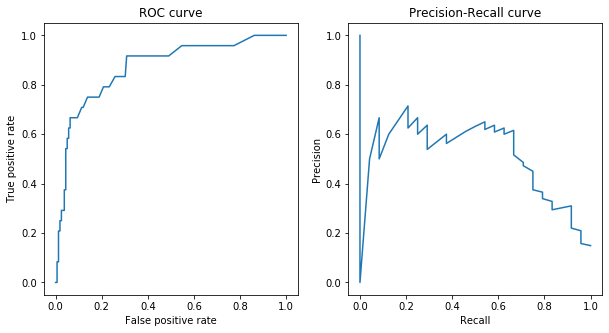

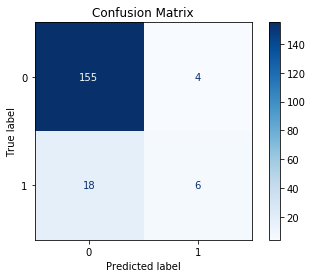

Precision: 0.88
Recall: 0.25
Recall class 0: 0.97
Recall class 1: 0.25
Balanced accuracy: 0.61
Area under the curve ROC: 0.87
F1 score: 0.35
Average precision score: 0.53


In [20]:
models['BASE'] = dict()
models['BASE']['LABEL'] = 'Base';

models['BASE']['RF'] = RandomForestClassifier(random_state=0,
                                              n_jobs=-1
                                             )

models['BASE']['RF'].fit(X_train, Y_train)

# Assess_quality
models['BASE'] = assess_quality(model=models['BASE'],
                                X=X_test,
                                Y=Y_test,
                                show_curves=True
                               )

<a id='balanced_RFC'></a>

---
## Balanced Random Forest Classifier: Base Model

Now, we implemented `BalancedRandomForestClassifier` from the imbalanced-learning library. We keep all the default parameters, except for the parameters `random_state=0` and `n_jobs=-1`. We will refer to this model as the base model of a balanced RFC (BRFC).

In the cell below, we instatiate `BalancedRandomForestClassifier` and fit the model with the same data used in the base RFC.

From looking at the confusion matrix and recall, **we immediately observe a huge improvement with respect to the base model**, that is, accuracy for predicting device failure (recall for class 1) goes from 0.25 in the base model of RFC to 0.79 in this based model of BRFC. On the other hand, accuracy for predicting non-failure (recall for class 0) drops from 0.97 in the base RFC to 0.75 in the base BRFC. 

This model seems to have a better trade-off between predicting device failure and non-failure. Below now we will look for methods for further improve the accuracy of the BRFC.

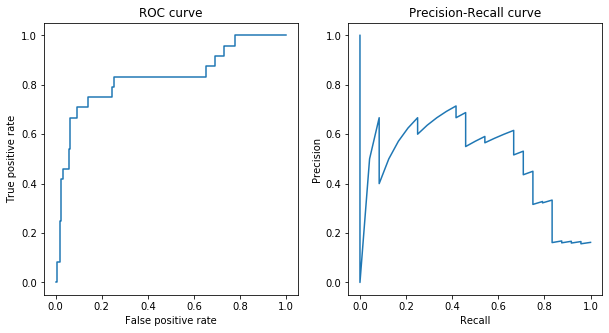

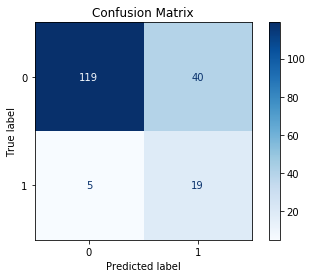

Precision: 0.75
Recall: 0.79
Recall class 0: 0.75
Recall class 1: 0.79
Balanced accuracy: 0.77
Area under the curve ROC: 0.83
F1 score: 0.46
Average precision score: 0.51


In [21]:
models['B_BASE'] = dict()
models['B_BASE']['LABEL'] = 'Balanced base';

models['B_BASE']['RF'] = BalancedRandomForestClassifier(random_state=0,
                                 n_jobs=-1
                                )

models['B_BASE']['RF'].fit(X_train, Y_train)

# Assess_quality
models['B_BASE'] = assess_quality(model=models['B_BASE'],
                                  X=X_test,
                                  Y=Y_test,
                                  show_curves=True
                                 )

<span style="color:red">**IMPORTANT NOTE:**</span> From comparing ROC and Precision-Recall curves for the base RFC and the base BRFC we observe that these metrics are misleading, and do not reflect the accuracy for predicting device failure. Therefore, from this point on only recall for class 0 and 1 together with balanced accuracy will be used to measure model performance.

The cell below plots the ROC and the Precision-Recall curves for the base RFC and the base BRFC. As mentioned before, these metrics are misleading, not reflecting the real accuracy for predicting the minority class (device failure) in our dataset.

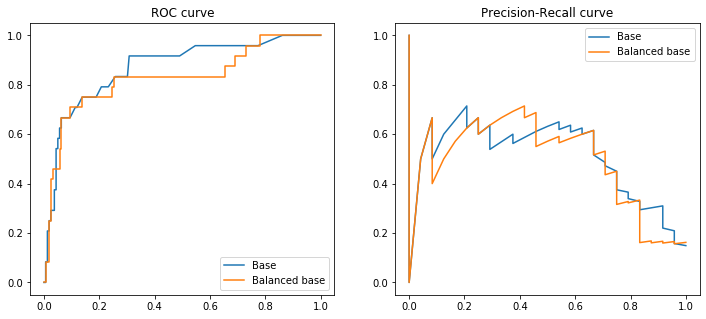

In [22]:
# Comparison of current model's ROC and Precision-curves with base model's
compare_model_curves(models['BASE'], models['B_BASE'])

<a id='feature_selection'></a>

---
## Feature Selection

We now perform [feature selection](https://scikit-learn.org/stable/modules/feature_selection.html) of the training data to try to improve the accuracy of our base BRFC.

Feature selection will effectively reduce the number of features (attribute values) in the train and test data by selecting a subset of features that show the higher correlation score with the target variable (failure). 

We can check the number of features in our train and test data as shown below:

In [23]:
X_train.shape

(426, 126)

where 126 is the number of columns in `X_train`, that is, the number of features.

In the cell below we implemented two functions for selecting a subset of features using standard correlation (`feature_selection_correlation`), and using a $\chi^2$-test (`select_K_Best_Features`) between features and the target variable. In the former case, we compute the correlation between features and target variable using the built-in Pandas function `corr()`, while in the latter case we use the Scikit-Learn class [SelectKBest](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectKBest.html#sklearn.feature_selection.SelectKBest) with $\chi^2$-test as the scoring function.

When selecting features using correlation, we only take into account those features with positive correlation with the target variable. On the other hand, when using a $\chi^2$-test we use $1/4$, $1/2$, and $3/4$ the original number of features in `X_train` and `X_test`, then choose the model with feature selection showing higher accuracy.

In [24]:
def select_K_Best_Features(X_train, X_test, Y_train, num_features):
    """Selection of k best features using chi2 test. Training and test DataFrames returned"""
    KBest_selector = SelectKBest(chi2, k=num_features)
    KBest_selector.fit(X_train, Y_train)

    X_train_kbest = KBest_selector.transform(X_train)
    X_test_kbest = KBest_selector.transform(X_test)
    
    indices = KBest_selector.get_support()
    kbest_features = X_train.columns[indices]
    
    return X_train_kbest, X_test_kbest, kbest_features

def feature_selection_correlation(X_TRAIN, Y_TRAIN, X_TEST):
    """
    Function that computes the correlation between features and target variable and returns 
    positive correlated features only.
    """
    df_ = pd.concat([X_TRAIN, Y_TRAIN], axis='columns')
    
    corr = df_.corr().copy(deep=True)
    
    corr_target = corr[metadata['target']].sort_values(ascending=False,
                                                       inplace=False
                                                      )
    
    corr_target = corr_target.drop(index=metadata['target'])
    
    selected_features = corr_target[corr_target > 0.0].index.values.tolist()
    
    X_train_corr = X_TRAIN[selected_features]
    X_test_corr = X_TEST[selected_features]
    
    return X_train_corr, X_test_corr

def model_with_feature_selection(metadata, X_train, Y_train, X_test, Y_test, verbose=True):
    """Function that trains and evaluate balanced random forests classifiers using feature selection"""
    
    # Feature selection using SelectKBest with chi2 test for features
    fraction_of_features = [0.25, 0.5, 0.75]
    kbest_mods = []
    best_kbest = dict()
    for ii,frac in enumerate(fraction_of_features, start=0):
        num_features = int( frac*len(metadata['features']) )
        
        # Selection of k-best features
        X_train_kbest, X_test_kbest, kbest_features = select_K_Best_Features(X_train=X_train,
                                                                             X_test=X_test,
                                                                             Y_train=Y_train,
                                                                             num_features=num_features
                                                                            )
        
        # Instantiate and fit balanced random forest classifier
        kbest_mods.append( dict() )
        kbest_mods[ii]['NUM_FEATURES'] = num_features
        kbest_mods[ii]['RF'] = BalancedRandomForestClassifier(random_state=0,
                                                              n_jobs=-1
                                                             )
        
        kbest_mods[ii]['RF'].fit(X_train_kbest, Y_train)
    
        kbest_mods[ii] = assess_quality(model=kbest_mods[ii],
                                        X=X_test_kbest,
                                        Y=Y_test,
                                        show_curves=False,
                                        verbose=False
                                       )

        kbest_mods[ii]['X_TRAIN'] = X_train_kbest
        kbest_mods[ii]['X_TEST'] = X_test_kbest

        # Select best model using balanced accuracy
        if (len(best_kbest) == 0):
            best_kbest = kbest_mods[ii]
        else:
            if (best_kbest['BALANCED_ACCURACY'] < kbest_mods[ii]['BALANCED_ACCURACY']):
                best_kbest = kbest_mods[ii]
                
                
    # Feature selection using correlation
    X_train_corr, X_test_corr = feature_selection_correlation(X_TRAIN=X_train,
                                                              Y_TRAIN=Y_train,
                                                              X_TEST=X_test
                                                             )
    
    # Instantiate and fit balanced random forest classifier
    mod_corr = dict()
    mod_corr['NUM_FEATURES'] = X_train_corr.shape[1]
    
    mod_corr['RF'] = BalancedRandomForestClassifier(random_state=0,
                                                    n_jobs=-1
                                                   )

    mod_corr['RF'].fit(X_train_corr, Y_train)

    # Assess_quality
    mod_corr = assess_quality(model=mod_corr,
                              X=X_test_corr,
                              Y=Y_test,
                              show_curves=False,
                              verbose=False
                             )
    
    mod_corr['X_TRAIN'] = X_train_corr
    mod_corr['X_TEST'] = X_test_corr
    
    model = dict()
    print("MODEL WITH FEATURE SELECTION:")
    # Choose between kbest and correlation feature selection
    if (best_kbest['BALANCED_ACCURACY'] > mod_corr['BALANCED_ACCURACY']):
        model = best_kbest
        print("Best model with feature selection using CHI2 TEST")
    else:
        model = mod_corr
        print("Best model with feature selection using CORRELATION")
        
    model['LABEL'] = 'Feature selection'    
    
    print("Number of selected features: %4d (out of %4d)" % (model['NUM_FEATURES'], X_train.shape[1]) )

    # Brief resume of recalls
    if verbose:
        print("Balanced accuracy %1.2f" % model['BALANCED_ACCURACY'])
        print("Recall class 0: %1.2f" % model['RECALL_0'])
        print("Recall class 1: %1.2f" % model['RECALL_1'])
    
    return model

Next, both methods for feature selection are applied to the train and test data using the function `model_with_feature_selection`. This function returns the BRFC with feature selection that shows the best balanced accuracy. It also returns the train (`models['FEATURE_SELECTION']['X_TRAIN']`) and test (`models['FEATURE_SELECTION']['X_TEST']`) data used in the model.

In [25]:
models['FEATURE_SELECTION'] = dict()

models['FEATURE_SELECTION'] = model_with_feature_selection(metadata=metadata, 
                                                           X_train=X_train, 
                                                           Y_train=Y_train, 
                                                           X_test=X_test, 
                                                           Y_test=Y_test
                                                          )

MODEL WITH FEATURE SELECTION:
Best model with feature selection using CHI2 TEST
Number of selected features:   94 (out of  126)
Balanced accuracy 0.83
Recall class 0: 0.83
Recall class 1: 0.83


As seen from the execution of cell above, for this particular case where we use 14 days of historical data for predicting failure in a 5-day period time, **the number of features in `X_train` and `X_test` go from 126 to 94 using $\chi^2$-test, improving accuracy from 0.75 and 0.79 for class 0 and 1, respectively, to 0.83 in both cases.**

**Feature selection have improved our BRFC.** Now, we try to further improve this model using fine-tuning of the hyperparameters used to implement the BRFC.

<a id='random_search_CV'></a>

---
## Hyperparameter Optimization

Further improvements to our BRFC might be achieved by using the best hyperparameters used in the implementation of the BRFC that use feature selection (see previous section).

We try different sets of parameters for implementing the BRFC with fearure selection, and through a cross-validation analysis choose the one with better [balanced accuracy](#metrics) (`BALANCED_ACCURACY`).

We implement the cross-validation analysis using the Scikit-Learn class [`RandomizedSearchCV`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html), which randomly chooses sub-sets of parameters for implementing the BRFC from the parameter space defined by the user.

In the cell below we set the parameter space to be used in the cross-validation analysis. All the posible values of parameters to be used in the BRFC implementation are kept in the dictionary `metadata['RSCV_params']`. 

We are mainly focused in trying different number of estimators (decision trees in random forest), going from 10 to 500. We explore the way nodes are split in estimators by varying the `min_samples_split` parameter. Also, we are interested in the way leaf nodes are defined `min_samples_leaf`. 

For our cross-validation test, we use 100 iterations in `RandomizedSearchCV`, meaning that we will test 100 set of parameters for implementing the BRFC, then we will choose between those 100 implementations the one with higher balanced accuracy.

In [26]:
metadata['RSCV_params'] = dict()
metadata['RSCV_params']['RSCV_iterations'] = 100
metadata['RSCV_params']['n_estimators'] = [None] + [x for x in range(10,500,50)]
metadata['RSCV_params']['max_features'] = ['auto', 'sqrt', None]
metadata['RSCV_params']['min_samples_split'] = [2, 10, 20]
metadata['RSCV_params']['min_samples_leaf'] = [1, 5, 10]
metadata['RSCV_params']['class_weight'] = [None, 'balanced','balanced_subsample']

In [27]:
def get_best_random_search_CV_model(metadata, X_train, Y_train, X_test, Y_test):
    """
    Function to optimize a balanced random forest through random search of optimal hyperparameters
    """
    
    print("HYPERPARAMETER OPTIMIZATION: ")
    
    # Create the random grid
    parameters_grid = {'n_estimators':metadata['RSCV_params']['n_estimators'],
                       'max_features':metadata['RSCV_params']['max_features'],
                       'min_samples_split':metadata['RSCV_params']['min_samples_split'],
                       'min_samples_leaf':metadata['RSCV_params']['min_samples_leaf'],
                       'class_weight':metadata['RSCV_params']['class_weight']
                      }

    # Random forest whose parameters will be optimized
    brf = BalancedRandomForestClassifier(random_state=0)

    brf_random = RandomizedSearchCV(estimator=brf,
                                    param_distributions=parameters_grid,
                                    n_iter = metadata['RSCV_params']['RSCV_iterations'], 
                                    scoring='balanced_accuracy',
                                    cv = None, 
                                    verbose=3, 
                                    random_state=0, 
                                    n_jobs=-1,
                                    return_train_score=True
                                   )

    # Fit model
    brf_random.fit(X_train, Y_train);

    best_brf_random = dict()
    
    best_brf_random['RF'] = brf_random.best_estimator_

    # Assess_quality
    best_brf_random = assess_quality(model=best_brf_random,
                                     X=X_test,
                                     Y=Y_test,
                                     show_curves=False,
                                     verbose=False
                                    )

    
    return best_brf_random

In [28]:
if (models['B_BASE']['BALANCED_ACCURACY'] > models['FEATURE_SELECTION']['BALANCED_ACCURACY']):
    print("Optimizing base balanced random forest classifier")
    
    models['RSCV'] = get_best_random_search_CV_model(metadata=metadata,
                                                     X_train=X_train, 
                                                     Y_train=Y_train, 
                                                     X_test=X_test, 
                                                     Y_test=Y_test
                                                    )
else:
    print("Optimizing balanced random forest classifier with feature selection")
    
    models['RSCV'] = get_best_random_search_CV_model(metadata=metadata,
                                                     X_train=models['FEATURE_SELECTION']['X_TRAIN'], 
                                                     Y_train=Y_train, 
                                                     X_test=models['FEATURE_SELECTION']['X_TEST'], 
                                                     Y_test=Y_test
                                                    )
    
# Brief resume of recalls
print("Balanced accuracy %1.2f" % models['RSCV']['BALANCED_ACCURACY'])
print("Recall class 0: %1.2f" % models['RSCV']['RECALL_0'])
print("Recall class 1: %1.2f" % models['RSCV']['RECALL_1'])
    
models['RSCV']['LABEL'] = 'Randomized search CV'

Optimizing balanced random forest classifier with feature selection
HYPERPARAMETER OPTIMIZATION: 
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done 256 tasks      | elapsed:   12.4s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   24.6s finished


Balanced accuracy 0.83
Recall class 0: 0.83
Recall class 1: 0.83


**In this case, our cross-validation analysis shows that no improvement in the accuracy of the BRFC with feature selection is achieved**. However, for other [scenarios with different prediction periods](#best_model) this shows a modest improvement.

<a id='comparison'></a>

---
## Model Comparison: Choosing the Best Performing Model

We finally compare all the models implemented above by using the [balanced accuracy score](#metrics).

The function `compare_BA_scores` in the following cell compares and plots the balanced accuracy for all the models. Choosing among these models the one with the best balanced accuracy.

In [29]:
def compare_BA_scores(metadata, models_dict, show_plot=True):
    list_models = list(models_dict.keys())
    y_pos = np.arange(len(list_models))
    score = [models_dict[model]['BALANCED_ACCURACY'] for model in list_models]
    
    S = pd.Series(data=score, index=list_models)

    higher_score = 100.0*S.max()
    model = S.idxmax()
    
    print("Higher Balanced Accuracy: %3.2f%% | %10s" % (higher_score, model))

    if show_plot:
        fig, ax = plt.subplots(figsize=(6,7))
        ax.grid(axis='both',
                 alpha=0.3
                )

        ax.barh(y_pos, score, align='center', alpha=0.8)
        for ii,model in enumerate(list_models):
            annotation = "{:3.2f}".format( 100.0*models_dict[model]['BALANCED_ACCURACY'] ) + "%"
            ax.annotate(s=annotation,
                        xy=(models_dict[model]['BALANCED_ACCURACY'] ,y_pos[ii])
                       )
        plt.yticks(y_pos, list_models)        
        plt.xlabel('Balanced Accuracy (%)')
        plt.xlim((0, 1))
        plt.title('Days prediction: %3d | Days historic data: %3d' % (metadata['days_of_prediction'], metadata['days_of_training_data']))

        plt.show()
        
    return higher_score, model

Higher Balanced Accuracy: 83.18% | FEATURE_SELECTION


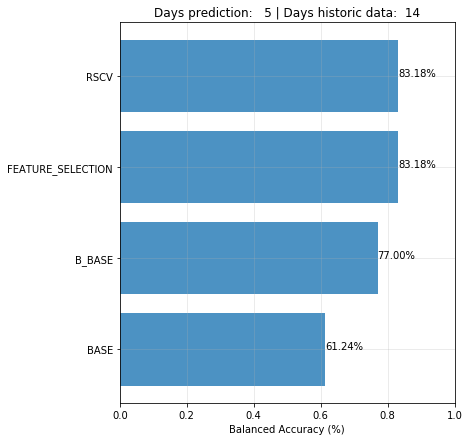

In [30]:
_, _ = compare_BA_scores(metadata, models)

For this exercise, where we use **14 days of historical data for predicting failure in a 5-day period time**, the **best model is a balanced random forest classifier with feature selection using a $\chi^2$-test**, achieving **83% of accuracy for predicting both device failure and non-failure**.

The following diagram shows the whole process we went through for finding the best model with higher accuracy. The red lines show the paths taken during decision making for choosing the best model.

![title](images/model_selection.png)

<a id='best_model'></a>

---
## Cross Validation Analysis for Finding Best Model: Varying Prediction Period

When the period of prediction can be varied and the number of days in historical data can be varied as well, we can repeat the whole processes described in previous sections, which is summarized in the figure above.

The function `search_best_model` in the cell below automates the whole process, giving as the **final result the model with higer balanced accuracy when we vary the period of prediction and the number of days in historical data for training the models**. 

**All the parameter used in the base BRFC as well as in the feature selection and hyperparameter optimization analysis remain unchanged, with respect to the values set in previous sections**.

In [31]:
def search_best_model(list_days_of_training_data, list_days_of_prediction):
    """
    Function that scans different values of days of prediction and days of historical data 
    to be used during training.
    """
    
    best_models = dict()
    
    for days_prediction in list_days_of_prediction:
    
        best_models[days_prediction] = dict()
        for days_training in list_days_of_training_data:
            print("\n")
            print("DAYS OF PREDICTION: %3d | DAYS OF TRAINING DATA: %3d"  % (days_prediction, days_training))
            
            metadata['days_of_training_data'] = days_training
            metadata['days_of_prediction'] = days_prediction
            metadata['total_days_of_data'] = metadata['days_of_training_data'] + metadata['days_of_prediction']

            df_model = generate_model_dataset(df=df_raw_data,
                                              df_analysis=data_analysis,
                                              metadata=metadata
                                             )

            # Data split in training and test subsets
            X_train, X_test, Y_train, Y_test = split_data(metadata, df_model)
            
            # Dictionary keeping different models
            mods = dict()
    
            # Base model (Balanced Random Forest Classifier)
            mods['B_BASE'] = dict()
            mods['B_BASE']['LABEL'] = 'Balanced base';

            mods['B_BASE']['RF'] = BalancedRandomForestClassifier(random_state=0,
                                                                  n_jobs=-1
                                                                 )

            mods['B_BASE']['RF'].fit(X_train, Y_train)

            # Assess_quality
            mods['B_BASE'] = assess_quality(model=mods['B_BASE'],
                                            X=X_test,
                                            Y=Y_test,
                                            show_curves=False,
                                            verbose=False
                                           )

            # Feature reduction
            mods['FEATURE_SELECTION'] = dict()

            mods['FEATURE_SELECTION'] = model_with_feature_selection(metadata=metadata, 
                                                                     X_train=X_train, 
                                                                     Y_train=Y_train, 
                                                                     X_test=X_test, 
                                                                     Y_test=Y_test,
                                                                     verbose=False
                                                                    )

            # Random search of hyperparameters
            if (mods['B_BASE']['BALANCED_ACCURACY'] > mods['FEATURE_SELECTION']['BALANCED_ACCURACY']):
                mods['RSCV'] = get_best_random_search_CV_model(metadata=metadata,
                                                               X_train=X_train, 
                                                               Y_train=Y_train, 
                                                               X_test=X_test, 
                                                               Y_test=Y_test
                                                              )
            else:
                mods['RSCV'] = get_best_random_search_CV_model(metadata=metadata,
                                                               X_train=mods['FEATURE_SELECTION']['X_TRAIN'], 
                                                               Y_train=Y_train, 
                                                               X_test=mods['FEATURE_SELECTION']['X_TEST'], 
                                                               Y_test=Y_test
                                                              )
            
            
            
            # Model comparison
            best_models[days_prediction][days_training] = dict()
            best_models[days_prediction][days_training]['score'], best_models[days_prediction][days_training]['model'] = compare_BA_scores(metadata, 
                                                                                                                                           mods, 
                                                                                                                                           False
                                                                                                                                          )
            
    best_model = dict()
    best_model['DAYS_OF_PREDICTION'] = 0
    best_model['DAYS_OF_TRAINING_DATA'] = 0
    best_model['SCORE'] = 0
    best_model['MODEL'] = ""
    
    for days_prediction in list_days_of_prediction:
        for days_training in list_days_of_training_data:
            if (len(best_model) == 0):
                best_model['DAYS_OF_PREDICTION'] = days_prediction
                best_model['DAYS_OF_TRAINING_DATA'] = days_training
                best_model['SCORE'] = best_models[days_prediction][days_training]['score']
                best_model['MODEL'] = best_models[days_prediction][days_training]['model']
            else:
                if(best_models[days_prediction][days_training]['score'] > best_model['SCORE']):
                    best_model['DAYS_OF_PREDICTION'] = days_prediction
                    best_model['DAYS_OF_TRAINING_DATA'] = days_training
                    best_model['SCORE'] = best_models[days_prediction][days_training]['score']
                    best_model['MODEL'] = best_models[days_prediction][days_training]['model']
                
    print("BEST MODEL: ")
    print("MODEL STRATEGY: ", best_model['MODEL'])
    print("BALANCED ACCURACY: %3.2f%%" % best_model['SCORE'])
    print("DAYS OF PREDICTION: ", best_model['DAYS_OF_PREDICTION'])
    print("DAYS OF HISOTORICAL DATA: ", best_model['DAYS_OF_TRAINING_DATA'])

    

We set the number of days of historical data to be tested in the list `list_days_of_training_data`, and the days of prediction to be tested in the list `list_days_of_prediction`.

## Conclusion from Cross-Validation Analysis

For an easier reading of the main results, we summarize our findings here, which are drawn from a careful analysis of the [cross-validation results](#end_of_notebook).

From the cross-validation analysis we find that the best model for predicting device failure is a **balanced random forest classifier with feature selection, with 88% of balanced accuracy using 14 days of historical data for predicting device failure in a 2-day period time**. 

The second best model found through the cross-validation analysis is a **balanced random forest classifier with hyperparameter optimization, with 87% of balanced accuracy using 14 days of historical data for predicting device failure in a 1-day period time**. 

The third best model found through the cross-validation analysis is a **balanced random forest classifier with feature selection, with 85% of balanced accuracy using 10 days of historical data for predicting device failure in a 6-day period time**. 

Depending on the desired period of time for the prediction, **one might choose between higher accurate models for 1- or 2-days predictions, or slightly less accurate models with relatively longer (6-day) predictions**.

In [32]:
list_days_of_training_data = [5, 7, 10, 14, 20]
list_days_of_prediction = [d for d in range(1,15)]

search_best_model(list_days_of_training_data=list_days_of_training_data,
                  list_days_of_prediction=list_days_of_prediction
                 )



DAYS OF PREDICTION:   1 | DAYS OF TRAINING DATA:   5
DATA PREPARATION: 
Number of devices to be used:  887
Number of failing devices in dataset: 10.15%
Number of working devices in dataset: 89.85%



DATA SPLITTING: 
Rows (devices) in dataset:  887
Rows (devices) in train subset:  620
Rows (devices) in test subset:  267
MODEL WITH FEATURE SELECTION:
Best model with feature selection using CORRELATION
Number of selected features:   27 (out of   45)
HYPERPARAMETER OPTIMIZATION: 
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done 151 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done 320 tasks      | elapsed:   14.0s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   22.7s finished


Higher Balanced Accuracy: 82.38% |     B_BASE


DAYS OF PREDICTION:   1 | DAYS OF TRAINING DATA:   7
DATA PREPARATION: 
Number of devices to be used:  636
Number of failing devices in dataset: 13.99%
Number of working devices in dataset: 86.01%



DATA SPLITTING: 
Rows (devices) in dataset:  636
Rows (devices) in train subset:  445
Rows (devices) in test subset:  191
MODEL WITH FEATURE SELECTION:
Best model with feature selection using CORRELATION
Number of selected features:   40 (out of   63)
HYPERPARAMETER OPTIMIZATION: 
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done 151 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done 320 tasks      | elapsed:   13.6s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   22.0s finished


Higher Balanced Accuracy: 81.58% |     B_BASE


DAYS OF PREDICTION:   1 | DAYS OF TRAINING DATA:  10
DATA PREPARATION: 
Number of devices to be used:  635
Number of failing devices in dataset: 13.86%
Number of working devices in dataset: 86.14%



DATA SPLITTING: 
Rows (devices) in dataset:  635
Rows (devices) in train subset:  444
Rows (devices) in test subset:  191
MODEL WITH FEATURE SELECTION:
Best model with feature selection using CORRELATION
Number of selected features:   56 (out of   90)
HYPERPARAMETER OPTIMIZATION: 
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done 151 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done 320 tasks      | elapsed:   13.7s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   22.2s finished


Higher Balanced Accuracy: 81.89% | FEATURE_SELECTION


DAYS OF PREDICTION:   1 | DAYS OF TRAINING DATA:  14
DATA PREPARATION: 
Number of devices to be used:  611
Number of failing devices in dataset: 14.08%
Number of working devices in dataset: 85.92%



DATA SPLITTING: 
Rows (devices) in dataset:  611
Rows (devices) in train subset:  427
Rows (devices) in test subset:  184
MODEL WITH FEATURE SELECTION:
Best model with feature selection using CHI2 TEST
Number of selected features:   63 (out of  126)
HYPERPARAMETER OPTIMIZATION: 
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    5.8s
[Parallel(n_jobs=-1)]: Done 320 tasks      | elapsed:   14.1s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   22.9s finished


Higher Balanced Accuracy: 87.22% |       RSCV


DAYS OF PREDICTION:   1 | DAYS OF TRAINING DATA:  20
DATA PREPARATION: 
Number of devices to be used:  600
Number of failing devices in dataset: 12.50%
Number of working devices in dataset: 87.50%



DATA SPLITTING: 
Rows (devices) in dataset:  600
Rows (devices) in train subset:  420
Rows (devices) in test subset:  180
MODEL WITH FEATURE SELECTION:
Best model with feature selection using CORRELATION
Number of selected features:  105 (out of  180)
HYPERPARAMETER OPTIMIZATION: 
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done 151 tasks      | elapsed:    5.8s
[Parallel(n_jobs=-1)]: Done 320 tasks      | elapsed:   14.0s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   22.8s finished


Higher Balanced Accuracy: 81.89% | FEATURE_SELECTION


DAYS OF PREDICTION:   2 | DAYS OF TRAINING DATA:   5
DATA PREPARATION: 
Number of devices to be used:  678
Number of failing devices in dataset: 13.27%
Number of working devices in dataset: 86.73%



DATA SPLITTING: 
Rows (devices) in dataset:  678
Rows (devices) in train subset:  474
Rows (devices) in test subset:  204
MODEL WITH FEATURE SELECTION:
Best model with feature selection using CHI2 TEST
Number of selected features:   33 (out of   45)
HYPERPARAMETER OPTIMIZATION: 
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done 151 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done 320 tasks      | elapsed:   13.6s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   21.9s finished


Higher Balanced Accuracy: 75.32% |       RSCV


DAYS OF PREDICTION:   2 | DAYS OF TRAINING DATA:   7
DATA PREPARATION: 
Number of devices to be used:  636
Number of failing devices in dataset: 13.99%
Number of working devices in dataset: 86.01%



DATA SPLITTING: 
Rows (devices) in dataset:  636
Rows (devices) in train subset:  445
Rows (devices) in test subset:  191
MODEL WITH FEATURE SELECTION:
Best model with feature selection using CHI2 TEST
Number of selected features:   31 (out of   63)
HYPERPARAMETER OPTIMIZATION: 
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done 151 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done 320 tasks      | elapsed:   13.5s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   21.8s finished


Higher Balanced Accuracy: 78.56% |       RSCV


DAYS OF PREDICTION:   2 | DAYS OF TRAINING DATA:  10
DATA PREPARATION: 
Number of devices to be used:  635
Number of failing devices in dataset: 13.86%
Number of working devices in dataset: 86.14%



DATA SPLITTING: 
Rows (devices) in dataset:  635
Rows (devices) in train subset:  444
Rows (devices) in test subset:  191
MODEL WITH FEATURE SELECTION:
Best model with feature selection using CORRELATION
Number of selected features:   56 (out of   90)
HYPERPARAMETER OPTIMIZATION: 
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done 151 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done 320 tasks      | elapsed:   13.7s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   22.2s finished


Higher Balanced Accuracy: 81.09% | FEATURE_SELECTION


DAYS OF PREDICTION:   2 | DAYS OF TRAINING DATA:  14
DATA PREPARATION: 
Number of devices to be used:  611
Number of failing devices in dataset: 14.08%
Number of working devices in dataset: 85.92%



DATA SPLITTING: 
Rows (devices) in dataset:  611
Rows (devices) in train subset:  427
Rows (devices) in test subset:  184
MODEL WITH FEATURE SELECTION:
Best model with feature selection using CORRELATION
Number of selected features:   91 (out of  126)
HYPERPARAMETER OPTIMIZATION: 
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done 320 tasks      | elapsed:   14.4s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   23.4s finished


Higher Balanced Accuracy: 88.51% | FEATURE_SELECTION


DAYS OF PREDICTION:   2 | DAYS OF TRAINING DATA:  20
DATA PREPARATION: 
Number of devices to be used:  600
Number of failing devices in dataset: 12.50%
Number of working devices in dataset: 87.50%



DATA SPLITTING: 
Rows (devices) in dataset:  600
Rows (devices) in train subset:  420
Rows (devices) in test subset:  180
MODEL WITH FEATURE SELECTION:
Best model with feature selection using CHI2 TEST
Number of selected features:  135 (out of  180)
HYPERPARAMETER OPTIMIZATION: 
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    5.8s
[Parallel(n_jobs=-1)]: Done 320 tasks      | elapsed:   14.4s


Higher Balanced Accuracy: 77.08% | FEATURE_SELECTION


DAYS OF PREDICTION:   3 | DAYS OF TRAINING DATA:   5
DATA PREPARATION: 
Number of devices to be used:  636
Number of failing devices in dataset: 13.99%
Number of working devices in dataset: 86.01%


[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   23.6s finished



DATA SPLITTING: 
Rows (devices) in dataset:  636
Rows (devices) in train subset:  445
Rows (devices) in test subset:  191
MODEL WITH FEATURE SELECTION:
Best model with feature selection using CHI2 TEST
Number of selected features:   22 (out of   45)
HYPERPARAMETER OPTIMIZATION: 
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done 151 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done 320 tasks      | elapsed:   13.4s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   21.7s finished


Higher Balanced Accuracy: 76.27% | FEATURE_SELECTION


DAYS OF PREDICTION:   3 | DAYS OF TRAINING DATA:   7
DATA PREPARATION: 
Number of devices to be used:  635
Number of failing devices in dataset: 13.86%
Number of working devices in dataset: 86.14%



DATA SPLITTING: 
Rows (devices) in dataset:  635
Rows (devices) in train subset:  444
Rows (devices) in test subset:  191
MODEL WITH FEATURE SELECTION:
Best model with feature selection using CHI2 TEST
Number of selected features:   47 (out of   63)
HYPERPARAMETER OPTIMIZATION: 
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done 151 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done 320 tasks      | elapsed:   13.7s


Higher Balanced Accuracy: 75.79% |       RSCV


DAYS OF PREDICTION:   3 | DAYS OF TRAINING DATA:  10
DATA PREPARATION: 
Number of devices to be used:  635
Number of failing devices in dataset: 13.86%
Number of working devices in dataset: 86.14%


[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   22.3s finished



DATA SPLITTING: 
Rows (devices) in dataset:  635
Rows (devices) in train subset:  444
Rows (devices) in test subset:  191
MODEL WITH FEATURE SELECTION:
Best model with feature selection using CORRELATION
Number of selected features:   56 (out of   90)
HYPERPARAMETER OPTIMIZATION: 
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done 151 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done 320 tasks      | elapsed:   13.8s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   22.3s finished


Higher Balanced Accuracy: 74.99% | FEATURE_SELECTION


DAYS OF PREDICTION:   3 | DAYS OF TRAINING DATA:  14
DATA PREPARATION: 
Number of devices to be used:  611
Number of failing devices in dataset: 14.08%
Number of working devices in dataset: 85.92%



DATA SPLITTING: 
Rows (devices) in dataset:  611
Rows (devices) in train subset:  427
Rows (devices) in test subset:  184
MODEL WITH FEATURE SELECTION:
Best model with feature selection using CHI2 TEST
Number of selected features:   63 (out of  126)
HYPERPARAMETER OPTIMIZATION: 
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 320 tasks      | elapsed:   14.8s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   24.2s finished


Higher Balanced Accuracy: 83.08% |     B_BASE


DAYS OF PREDICTION:   3 | DAYS OF TRAINING DATA:  20
DATA PREPARATION: 
Number of devices to be used:  599
Number of failing devices in dataset: 12.35%
Number of working devices in dataset: 87.65%



DATA SPLITTING: 
Rows (devices) in dataset:  599
Rows (devices) in train subset:  419
Rows (devices) in test subset:  180
MODEL WITH FEATURE SELECTION:
Best model with feature selection using CORRELATION
Number of selected features:   89 (out of  180)
HYPERPARAMETER OPTIMIZATION: 
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done 151 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done 320 tasks      | elapsed:   13.7s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   22.4s finished


Higher Balanced Accuracy: 78.16% | FEATURE_SELECTION


DAYS OF PREDICTION:   4 | DAYS OF TRAINING DATA:   5
DATA PREPARATION: 
Number of devices to be used:  636
Number of failing devices in dataset: 13.99%
Number of working devices in dataset: 86.01%



DATA SPLITTING: 
Rows (devices) in dataset:  636
Rows (devices) in train subset:  445
Rows (devices) in test subset:  191
MODEL WITH FEATURE SELECTION:
Best model with feature selection using CHI2 TEST
Number of selected features:   22 (out of   45)
HYPERPARAMETER OPTIMIZATION: 
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done 151 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done 320 tasks      | elapsed:   13.4s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   21.6s finished


Higher Balanced Accuracy: 75.96% | FEATURE_SELECTION


DAYS OF PREDICTION:   4 | DAYS OF TRAINING DATA:   7
DATA PREPARATION: 
Number of devices to be used:  635
Number of failing devices in dataset: 13.86%
Number of working devices in dataset: 86.14%



DATA SPLITTING: 
Rows (devices) in dataset:  635
Rows (devices) in train subset:  444
Rows (devices) in test subset:  191
MODEL WITH FEATURE SELECTION:
Best model with feature selection using CORRELATION
Number of selected features:   39 (out of   63)
HYPERPARAMETER OPTIMIZATION: 
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done 151 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done 320 tasks      | elapsed:   13.6s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   21.9s finished


Higher Balanced Accuracy: 74.68% |       RSCV


DAYS OF PREDICTION:   4 | DAYS OF TRAINING DATA:  10
DATA PREPARATION: 
Number of devices to be used:  612
Number of failing devices in dataset: 14.22%
Number of working devices in dataset: 85.78%



DATA SPLITTING: 
Rows (devices) in dataset:  612
Rows (devices) in train subset:  428
Rows (devices) in test subset:  184
MODEL WITH FEATURE SELECTION:
Best model with feature selection using CHI2 TEST
Number of selected features:   67 (out of   90)
HYPERPARAMETER OPTIMIZATION: 
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done 151 tasks      | elapsed:    5.8s
[Parallel(n_jobs=-1)]: Done 320 tasks      | elapsed:   13.9s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   22.6s finished


Higher Balanced Accuracy: 79.54% | FEATURE_SELECTION


DAYS OF PREDICTION:   4 | DAYS OF TRAINING DATA:  14
DATA PREPARATION: 
Number of devices to be used:  610
Number of failing devices in dataset: 13.93%
Number of working devices in dataset: 86.07%



DATA SPLITTING: 
Rows (devices) in dataset:  610
Rows (devices) in train subset:  427
Rows (devices) in test subset:  183
MODEL WITH FEATURE SELECTION:
Best model with feature selection using CHI2 TEST
Number of selected features:   63 (out of  126)
HYPERPARAMETER OPTIMIZATION: 
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    5.8s
[Parallel(n_jobs=-1)]: Done 320 tasks      | elapsed:   14.2s


Higher Balanced Accuracy: 82.35% | FEATURE_SELECTION


DAYS OF PREDICTION:   4 | DAYS OF TRAINING DATA:  20
DATA PREPARATION: 
Number of devices to be used:  597
Number of failing devices in dataset: 12.06%
Number of working devices in dataset: 87.94%


[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   23.1s finished



DATA SPLITTING: 
Rows (devices) in dataset:  597
Rows (devices) in train subset:  417
Rows (devices) in test subset:  180
MODEL WITH FEATURE SELECTION:
Best model with feature selection using CHI2 TEST
Number of selected features:  135 (out of  180)
HYPERPARAMETER OPTIMIZATION: 
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 320 tasks      | elapsed:   15.0s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   24.7s finished


Higher Balanced Accuracy: 78.75% |     B_BASE


DAYS OF PREDICTION:   5 | DAYS OF TRAINING DATA:   5
DATA PREPARATION: 
Number of devices to be used:  635
Number of failing devices in dataset: 13.86%
Number of working devices in dataset: 86.14%



DATA SPLITTING: 
Rows (devices) in dataset:  635
Rows (devices) in train subset:  444
Rows (devices) in test subset:  191
MODEL WITH FEATURE SELECTION:
Best model with feature selection using CORRELATION
Number of selected features:   29 (out of   45)
HYPERPARAMETER OPTIMIZATION: 
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done 151 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done 320 tasks      | elapsed:   13.5s


Higher Balanced Accuracy: 72.34% | FEATURE_SELECTION


DAYS OF PREDICTION:   5 | DAYS OF TRAINING DATA:   7
DATA PREPARATION: 
Number of devices to be used:  635
Number of failing devices in dataset: 13.86%
Number of working devices in dataset: 86.14%


[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   21.8s finished



DATA SPLITTING: 
Rows (devices) in dataset:  635
Rows (devices) in train subset:  444
Rows (devices) in test subset:  191
MODEL WITH FEATURE SELECTION:
Best model with feature selection using CORRELATION
Number of selected features:   40 (out of   63)
HYPERPARAMETER OPTIMIZATION: 
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done 151 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done 320 tasks      | elapsed:   13.6s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   22.0s finished


Higher Balanced Accuracy: 71.72% | FEATURE_SELECTION


DAYS OF PREDICTION:   5 | DAYS OF TRAINING DATA:  10
DATA PREPARATION: 
Number of devices to be used:  611
Number of failing devices in dataset: 14.08%
Number of working devices in dataset: 85.92%



DATA SPLITTING: 
Rows (devices) in dataset:  611
Rows (devices) in train subset:  427
Rows (devices) in test subset:  184
MODEL WITH FEATURE SELECTION:
Best model with feature selection using CORRELATION
Number of selected features:   64 (out of   90)
HYPERPARAMETER OPTIMIZATION: 
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done 320 tasks      | elapsed:   14.1s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   22.9s finished


Higher Balanced Accuracy: 80.84% | FEATURE_SELECTION


DAYS OF PREDICTION:   5 | DAYS OF TRAINING DATA:  14
DATA PREPARATION: 
Number of devices to be used:  609
Number of failing devices in dataset: 13.79%
Number of working devices in dataset: 86.21%



DATA SPLITTING: 
Rows (devices) in dataset:  609
Rows (devices) in train subset:  426
Rows (devices) in test subset:  183
MODEL WITH FEATURE SELECTION:
Best model with feature selection using CHI2 TEST
Number of selected features:   94 (out of  126)
HYPERPARAMETER OPTIMIZATION: 
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done 320 tasks      | elapsed:   14.3s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   23.5s finished


Higher Balanced Accuracy: 83.18% | FEATURE_SELECTION


DAYS OF PREDICTION:   5 | DAYS OF TRAINING DATA:  20
DATA PREPARATION: 
Number of devices to be used:  597
Number of failing devices in dataset: 12.06%
Number of working devices in dataset: 87.94%



DATA SPLITTING: 
Rows (devices) in dataset:  597
Rows (devices) in train subset:  417
Rows (devices) in test subset:  180
MODEL WITH FEATURE SELECTION:
Best model with feature selection using CORRELATION
Number of selected features:  105 (out of  180)
HYPERPARAMETER OPTIMIZATION: 
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done 151 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done 320 tasks      | elapsed:   14.1s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   23.0s finished


Higher Balanced Accuracy: 76.25% | FEATURE_SELECTION


DAYS OF PREDICTION:   6 | DAYS OF TRAINING DATA:   5
DATA PREPARATION: 
Number of devices to be used:  635
Number of failing devices in dataset: 13.86%
Number of working devices in dataset: 86.14%



DATA SPLITTING: 
Rows (devices) in dataset:  635
Rows (devices) in train subset:  444
Rows (devices) in test subset:  191
MODEL WITH FEATURE SELECTION:
Best model with feature selection using CHI2 TEST
Number of selected features:   33 (out of   45)
HYPERPARAMETER OPTIMIZATION: 
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done 151 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done 320 tasks      | elapsed:   13.7s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   22.2s finished


Higher Balanced Accuracy: 70.80% |     B_BASE


DAYS OF PREDICTION:   6 | DAYS OF TRAINING DATA:   7
DATA PREPARATION: 
Number of devices to be used:  635
Number of failing devices in dataset: 13.86%
Number of working devices in dataset: 86.14%



DATA SPLITTING: 
Rows (devices) in dataset:  635
Rows (devices) in train subset:  444
Rows (devices) in test subset:  191
MODEL WITH FEATURE SELECTION:
Best model with feature selection using CORRELATION
Number of selected features:   40 (out of   63)
HYPERPARAMETER OPTIMIZATION: 
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done 151 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done 320 tasks      | elapsed:   13.6s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   22.0s finished


Higher Balanced Accuracy: 71.72% |       RSCV


DAYS OF PREDICTION:   6 | DAYS OF TRAINING DATA:  10
DATA PREPARATION: 
Number of devices to be used:  611
Number of failing devices in dataset: 14.08%
Number of working devices in dataset: 85.92%



DATA SPLITTING: 
Rows (devices) in dataset:  611
Rows (devices) in train subset:  427
Rows (devices) in test subset:  184
MODEL WITH FEATURE SELECTION:
Best model with feature selection using CHI2 TEST
Number of selected features:   67 (out of   90)
HYPERPARAMETER OPTIMIZATION: 
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done 151 tasks      | elapsed:    5.8s
[Parallel(n_jobs=-1)]: Done 320 tasks      | elapsed:   14.0s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   22.8s finished


Higher Balanced Accuracy: 85.00% | FEATURE_SELECTION


DAYS OF PREDICTION:   6 | DAYS OF TRAINING DATA:  14
DATA PREPARATION: 
Number of devices to be used:  601
Number of failing devices in dataset: 12.65%
Number of working devices in dataset: 87.35%



DATA SPLITTING: 
Rows (devices) in dataset:  601
Rows (devices) in train subset:  420
Rows (devices) in test subset:  181
MODEL WITH FEATURE SELECTION:
Best model with feature selection using CHI2 TEST
Number of selected features:   94 (out of  126)
HYPERPARAMETER OPTIMIZATION: 
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done 151 tasks      | elapsed:    5.8s
[Parallel(n_jobs=-1)]: Done 320 tasks      | elapsed:   14.0s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   22.8s finished


Higher Balanced Accuracy: 69.44% | FEATURE_SELECTION


DAYS OF PREDICTION:   6 | DAYS OF TRAINING DATA:  20
DATA PREPARATION: 
Number of devices to be used:  597
Number of failing devices in dataset: 12.06%
Number of working devices in dataset: 87.94%



DATA SPLITTING: 
Rows (devices) in dataset:  597
Rows (devices) in train subset:  417
Rows (devices) in test subset:  180
MODEL WITH FEATURE SELECTION:
Best model with feature selection using CHI2 TEST
Number of selected features:  135 (out of  180)
HYPERPARAMETER OPTIMIZATION: 
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done 320 tasks      | elapsed:   15.0s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   24.7s finished


Higher Balanced Accuracy: 77.19% |     B_BASE


DAYS OF PREDICTION:   7 | DAYS OF TRAINING DATA:   5
DATA PREPARATION: 
Number of devices to be used:  635
Number of failing devices in dataset: 13.86%
Number of working devices in dataset: 86.14%



DATA SPLITTING: 
Rows (devices) in dataset:  635
Rows (devices) in train subset:  444
Rows (devices) in test subset:  191
MODEL WITH FEATURE SELECTION:
Best model with feature selection using CHI2 TEST
Number of selected features:   33 (out of   45)
HYPERPARAMETER OPTIMIZATION: 
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done 151 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done 320 tasks      | elapsed:   13.5s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   21.9s finished


Higher Balanced Accuracy: 70.49% |     B_BASE


DAYS OF PREDICTION:   7 | DAYS OF TRAINING DATA:   7
DATA PREPARATION: 
Number of devices to be used:  612
Number of failing devices in dataset: 14.22%
Number of working devices in dataset: 85.78%



DATA SPLITTING: 
Rows (devices) in dataset:  612
Rows (devices) in train subset:  428
Rows (devices) in test subset:  184
MODEL WITH FEATURE SELECTION:
Best model with feature selection using CORRELATION
Number of selected features:   44 (out of   63)
HYPERPARAMETER OPTIMIZATION: 
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done 151 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done 320 tasks      | elapsed:   13.7s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   22.1s finished


Higher Balanced Accuracy: 75.13% | FEATURE_SELECTION


DAYS OF PREDICTION:   7 | DAYS OF TRAINING DATA:  10
DATA PREPARATION: 
Number of devices to be used:  611
Number of failing devices in dataset: 14.08%
Number of working devices in dataset: 85.92%



DATA SPLITTING: 
Rows (devices) in dataset:  611
Rows (devices) in train subset:  427
Rows (devices) in test subset:  184
MODEL WITH FEATURE SELECTION:
Best model with feature selection using CHI2 TEST
Number of selected features:   45 (out of   90)
HYPERPARAMETER OPTIMIZATION: 
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done 151 tasks      | elapsed:    5.8s
[Parallel(n_jobs=-1)]: Done 320 tasks      | elapsed:   13.9s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   22.5s finished


Higher Balanced Accuracy: 76.70% | FEATURE_SELECTION


DAYS OF PREDICTION:   7 | DAYS OF TRAINING DATA:  14
DATA PREPARATION: 
Number of devices to be used:  600
Number of failing devices in dataset: 12.50%
Number of working devices in dataset: 87.50%



DATA SPLITTING: 
Rows (devices) in dataset:  600
Rows (devices) in train subset:  420
Rows (devices) in test subset:  180
MODEL WITH FEATURE SELECTION:
Best model with feature selection using CHI2 TEST
Number of selected features:   63 (out of  126)
HYPERPARAMETER OPTIMIZATION: 
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done 151 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done 320 tasks      | elapsed:   13.9s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   22.6s finished


Higher Balanced Accuracy: 71.96% | FEATURE_SELECTION


DAYS OF PREDICTION:   7 | DAYS OF TRAINING DATA:  20
DATA PREPARATION: 
Number of devices to be used:  596
Number of failing devices in dataset: 11.91%
Number of working devices in dataset: 88.09%



DATA SPLITTING: 
Rows (devices) in dataset:  596
Rows (devices) in train subset:  417
Rows (devices) in test subset:  179
MODEL WITH FEATURE SELECTION:
Best model with feature selection using CORRELATION
Number of selected features:   96 (out of  180)
HYPERPARAMETER OPTIMIZATION: 
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 320 tasks      | elapsed:   15.0s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   24.6s finished


Higher Balanced Accuracy: 74.65% |       RSCV


DAYS OF PREDICTION:   8 | DAYS OF TRAINING DATA:   5
DATA PREPARATION: 
Number of devices to be used:  635
Number of failing devices in dataset: 13.86%
Number of working devices in dataset: 86.14%



DATA SPLITTING: 
Rows (devices) in dataset:  635
Rows (devices) in train subset:  444
Rows (devices) in test subset:  191
MODEL WITH FEATURE SELECTION:
Best model with feature selection using CORRELATION
Number of selected features:   28 (out of   45)
HYPERPARAMETER OPTIMIZATION: 
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done 151 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done 320 tasks      | elapsed:   13.7s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   22.3s finished


Higher Balanced Accuracy: 71.10% |     B_BASE


DAYS OF PREDICTION:   8 | DAYS OF TRAINING DATA:   7
DATA PREPARATION: 
Number of devices to be used:  611
Number of failing devices in dataset: 14.08%
Number of working devices in dataset: 85.92%



DATA SPLITTING: 
Rows (devices) in dataset:  611
Rows (devices) in train subset:  427
Rows (devices) in test subset:  184
MODEL WITH FEATURE SELECTION:
Best model with feature selection using CHI2 TEST
Number of selected features:   47 (out of   63)
HYPERPARAMETER OPTIMIZATION: 
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done 151 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done 320 tasks      | elapsed:   13.7s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   22.3s finished


Higher Balanced Accuracy: 77.65% | FEATURE_SELECTION


DAYS OF PREDICTION:   8 | DAYS OF TRAINING DATA:  10
DATA PREPARATION: 
Number of devices to be used:  610
Number of failing devices in dataset: 13.93%
Number of working devices in dataset: 86.07%



DATA SPLITTING: 
Rows (devices) in dataset:  610
Rows (devices) in train subset:  427
Rows (devices) in test subset:  183
MODEL WITH FEATURE SELECTION:
Best model with feature selection using CORRELATION
Number of selected features:   63 (out of   90)
HYPERPARAMETER OPTIMIZATION: 
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done 320 tasks      | elapsed:   14.4s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   23.4s finished


Higher Balanced Accuracy: 77.44% |     B_BASE


DAYS OF PREDICTION:   8 | DAYS OF TRAINING DATA:  14
DATA PREPARATION: 
Number of devices to be used:  600
Number of failing devices in dataset: 12.50%
Number of working devices in dataset: 87.50%



DATA SPLITTING: 
Rows (devices) in dataset:  600
Rows (devices) in train subset:  420
Rows (devices) in test subset:  180
MODEL WITH FEATURE SELECTION:
Best model with feature selection using CORRELATION
Number of selected features:   70 (out of  126)
HYPERPARAMETER OPTIMIZATION: 
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done 320 tasks      | elapsed:   14.4s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   23.6s finished


Higher Balanced Accuracy: 69.39% |     B_BASE


DAYS OF PREDICTION:   8 | DAYS OF TRAINING DATA:  20
DATA PREPARATION: 
Number of devices to be used:  596
Number of failing devices in dataset: 11.91%
Number of working devices in dataset: 88.09%



DATA SPLITTING: 
Rows (devices) in dataset:  596
Rows (devices) in train subset:  417
Rows (devices) in test subset:  179
MODEL WITH FEATURE SELECTION:
Best model with feature selection using CORRELATION
Number of selected features:   94 (out of  180)
HYPERPARAMETER OPTIMIZATION: 
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 320 tasks      | elapsed:   15.0s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   24.6s finished


Higher Balanced Accuracy: 74.03% |     B_BASE


DAYS OF PREDICTION:   9 | DAYS OF TRAINING DATA:   5
DATA PREPARATION: 
Number of devices to be used:  612
Number of failing devices in dataset: 14.22%
Number of working devices in dataset: 85.78%



DATA SPLITTING: 
Rows (devices) in dataset:  612
Rows (devices) in train subset:  428
Rows (devices) in test subset:  184
MODEL WITH FEATURE SELECTION:
Best model with feature selection using CHI2 TEST
Number of selected features:   33 (out of   45)
HYPERPARAMETER OPTIMIZATION: 
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done 151 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done 320 tasks      | elapsed:   13.5s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   21.8s finished


Higher Balanced Accuracy: 75.13% | FEATURE_SELECTION


DAYS OF PREDICTION:   9 | DAYS OF TRAINING DATA:   7
DATA PREPARATION: 
Number of devices to be used:  611
Number of failing devices in dataset: 14.08%
Number of working devices in dataset: 85.92%



DATA SPLITTING: 
Rows (devices) in dataset:  611
Rows (devices) in train subset:  427
Rows (devices) in test subset:  184
MODEL WITH FEATURE SELECTION:
Best model with feature selection using CHI2 TEST
Number of selected features:   47 (out of   63)
HYPERPARAMETER OPTIMIZATION: 
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done 151 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done 320 tasks      | elapsed:   13.7s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   22.2s finished


Higher Balanced Accuracy: 79.89% | FEATURE_SELECTION


DAYS OF PREDICTION:   9 | DAYS OF TRAINING DATA:  10
DATA PREPARATION: 
Number of devices to be used:  609
Number of failing devices in dataset: 13.79%
Number of working devices in dataset: 86.21%



DATA SPLITTING: 
Rows (devices) in dataset:  609
Rows (devices) in train subset:  426
Rows (devices) in test subset:  183
MODEL WITH FEATURE SELECTION:
Best model with feature selection using CHI2 TEST
Number of selected features:   67 (out of   90)
HYPERPARAMETER OPTIMIZATION: 
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done 151 tasks      | elapsed:    5.8s
[Parallel(n_jobs=-1)]: Done 320 tasks      | elapsed:   14.0s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   22.8s finished


Higher Balanced Accuracy: 78.26% | FEATURE_SELECTION


DAYS OF PREDICTION:   9 | DAYS OF TRAINING DATA:  14
DATA PREPARATION: 
Number of devices to be used:  599
Number of failing devices in dataset: 12.35%
Number of working devices in dataset: 87.65%



DATA SPLITTING: 
Rows (devices) in dataset:  599
Rows (devices) in train subset:  419
Rows (devices) in test subset:  180
MODEL WITH FEATURE SELECTION:
Best model with feature selection using CORRELATION
Number of selected features:   62 (out of  126)
HYPERPARAMETER OPTIMIZATION: 
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 320 tasks      | elapsed:   14.6s


Higher Balanced Accuracy: 74.13% |     B_BASE


DAYS OF PREDICTION:   9 | DAYS OF TRAINING DATA:  20
DATA PREPARATION: 
Number of devices to be used:  595
Number of failing devices in dataset: 11.76%
Number of working devices in dataset: 88.24%


[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   23.9s finished



DATA SPLITTING: 
Rows (devices) in dataset:  595
Rows (devices) in train subset:  416
Rows (devices) in test subset:  179
MODEL WITH FEATURE SELECTION:
Best model with feature selection using CORRELATION
Number of selected features:   84 (out of  180)
HYPERPARAMETER OPTIMIZATION: 
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done 151 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done 320 tasks      | elapsed:   13.5s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   21.9s finished


Higher Balanced Accuracy: 71.82% |       RSCV


DAYS OF PREDICTION:  10 | DAYS OF TRAINING DATA:   5
DATA PREPARATION: 
Number of devices to be used:  611
Number of failing devices in dataset: 14.08%
Number of working devices in dataset: 85.92%



DATA SPLITTING: 
Rows (devices) in dataset:  611
Rows (devices) in train subset:  427
Rows (devices) in test subset:  184
MODEL WITH FEATURE SELECTION:
Best model with feature selection using CHI2 TEST
Number of selected features:   33 (out of   45)
HYPERPARAMETER OPTIMIZATION: 
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done 151 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done 320 tasks      | elapsed:   13.5s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   21.9s finished


Higher Balanced Accuracy: 79.58% | FEATURE_SELECTION


DAYS OF PREDICTION:  10 | DAYS OF TRAINING DATA:   7
DATA PREPARATION: 
Number of devices to be used:  611
Number of failing devices in dataset: 14.08%
Number of working devices in dataset: 85.92%



DATA SPLITTING: 
Rows (devices) in dataset:  611
Rows (devices) in train subset:  427
Rows (devices) in test subset:  184
MODEL WITH FEATURE SELECTION:
Best model with feature selection using CHI2 TEST
Number of selected features:   47 (out of   63)
HYPERPARAMETER OPTIMIZATION: 
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done 151 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done 320 tasks      | elapsed:   13.7s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   22.2s finished


Higher Balanced Accuracy: 73.49% | FEATURE_SELECTION


DAYS OF PREDICTION:  10 | DAYS OF TRAINING DATA:  10
DATA PREPARATION: 
Number of devices to be used:  601
Number of failing devices in dataset: 12.65%
Number of working devices in dataset: 87.35%



DATA SPLITTING: 
Rows (devices) in dataset:  601
Rows (devices) in train subset:  420
Rows (devices) in test subset:  181
MODEL WITH FEATURE SELECTION:
Best model with feature selection using CHI2 TEST
Number of selected features:   45 (out of   90)
HYPERPARAMETER OPTIMIZATION: 
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done 151 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done 320 tasks      | elapsed:   13.5s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   21.9s finished


Higher Balanced Accuracy: 69.40% | FEATURE_SELECTION


DAYS OF PREDICTION:  10 | DAYS OF TRAINING DATA:  14
DATA PREPARATION: 
Number of devices to be used:  597
Number of failing devices in dataset: 12.06%
Number of working devices in dataset: 87.94%



DATA SPLITTING: 
Rows (devices) in dataset:  597
Rows (devices) in train subset:  417
Rows (devices) in test subset:  180
MODEL WITH FEATURE SELECTION:
Best model with feature selection using CORRELATION
Number of selected features:   72 (out of  126)
HYPERPARAMETER OPTIMIZATION: 
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done 151 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done 320 tasks      | elapsed:   13.8s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   22.5s finished


Higher Balanced Accuracy: 76.88% | FEATURE_SELECTION


DAYS OF PREDICTION:  10 | DAYS OF TRAINING DATA:  20
DATA PREPARATION: 
Number of devices to be used:  595
Number of failing devices in dataset: 11.76%
Number of working devices in dataset: 88.24%



DATA SPLITTING: 
Rows (devices) in dataset:  595
Rows (devices) in train subset:  416
Rows (devices) in test subset:  179
MODEL WITH FEATURE SELECTION:
Best model with feature selection using CORRELATION
Number of selected features:   84 (out of  180)
HYPERPARAMETER OPTIMIZATION: 
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done 151 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done 320 tasks      | elapsed:   13.5s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   21.9s finished


Higher Balanced Accuracy: 72.81% | FEATURE_SELECTION


DAYS OF PREDICTION:  11 | DAYS OF TRAINING DATA:   5
DATA PREPARATION: 
Number of devices to be used:  611
Number of failing devices in dataset: 14.08%
Number of working devices in dataset: 85.92%



DATA SPLITTING: 
Rows (devices) in dataset:  611
Rows (devices) in train subset:  427
Rows (devices) in test subset:  184
MODEL WITH FEATURE SELECTION:
Best model with feature selection using CHI2 TEST
Number of selected features:   33 (out of   45)
HYPERPARAMETER OPTIMIZATION: 
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done 151 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done 320 tasks      | elapsed:   13.5s


Higher Balanced Accuracy: 75.78% |       RSCV


DAYS OF PREDICTION:  11 | DAYS OF TRAINING DATA:   7
DATA PREPARATION: 
Number of devices to be used:  610
Number of failing devices in dataset: 13.93%
Number of working devices in dataset: 86.07%


[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   21.9s finished



DATA SPLITTING: 
Rows (devices) in dataset:  610
Rows (devices) in train subset:  427
Rows (devices) in test subset:  183
MODEL WITH FEATURE SELECTION:
Best model with feature selection using CORRELATION
Number of selected features:   44 (out of   63)
HYPERPARAMETER OPTIMIZATION: 
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done 151 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done 320 tasks      | elapsed:   13.8s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   22.4s finished


Higher Balanced Accuracy: 75.04% | FEATURE_SELECTION


DAYS OF PREDICTION:  11 | DAYS OF TRAINING DATA:  10
DATA PREPARATION: 
Number of devices to be used:  600
Number of failing devices in dataset: 12.50%
Number of working devices in dataset: 87.50%



DATA SPLITTING: 
Rows (devices) in dataset:  600
Rows (devices) in train subset:  420
Rows (devices) in test subset:  180
MODEL WITH FEATURE SELECTION:
Best model with feature selection using CHI2 TEST
Number of selected features:   45 (out of   90)
HYPERPARAMETER OPTIMIZATION: 
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done 151 tasks      | elapsed:    5.8s
[Parallel(n_jobs=-1)]: Done 320 tasks      | elapsed:   14.0s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   22.9s finished


Higher Balanced Accuracy: 72.12% |       RSCV


DAYS OF PREDICTION:  11 | DAYS OF TRAINING DATA:  14
DATA PREPARATION: 
Number of devices to be used:  597
Number of failing devices in dataset: 12.06%
Number of working devices in dataset: 87.94%



DATA SPLITTING: 
Rows (devices) in dataset:  597
Rows (devices) in train subset:  417
Rows (devices) in test subset:  180
MODEL WITH FEATURE SELECTION:
Best model with feature selection using CHI2 TEST
Number of selected features:   31 (out of  126)
HYPERPARAMETER OPTIMIZATION: 
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done 320 tasks      | elapsed:   14.5s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   23.7s finished


Higher Balanced Accuracy: 75.31% |     B_BASE


DAYS OF PREDICTION:  11 | DAYS OF TRAINING DATA:  20
DATA PREPARATION: 
Number of devices to be used:  595
Number of failing devices in dataset: 11.76%
Number of working devices in dataset: 88.24%



DATA SPLITTING: 
Rows (devices) in dataset:  595
Rows (devices) in train subset:  416
Rows (devices) in test subset:  179
MODEL WITH FEATURE SELECTION:
Best model with feature selection using CORRELATION
Number of selected features:   84 (out of  180)
HYPERPARAMETER OPTIMIZATION: 
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done 151 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done 320 tasks      | elapsed:   13.5s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   21.9s finished


Higher Balanced Accuracy: 69.90% | FEATURE_SELECTION


DAYS OF PREDICTION:  12 | DAYS OF TRAINING DATA:   5
DATA PREPARATION: 
Number of devices to be used:  611
Number of failing devices in dataset: 14.08%
Number of working devices in dataset: 85.92%



DATA SPLITTING: 
Rows (devices) in dataset:  611
Rows (devices) in train subset:  427
Rows (devices) in test subset:  184
MODEL WITH FEATURE SELECTION:
Best model with feature selection using CHI2 TEST
Number of selected features:   22 (out of   45)
HYPERPARAMETER OPTIMIZATION: 
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done 151 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done 320 tasks      | elapsed:   13.5s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   21.8s finished


Higher Balanced Accuracy: 73.49% |       RSCV


DAYS OF PREDICTION:  12 | DAYS OF TRAINING DATA:   7
DATA PREPARATION: 
Number of devices to be used:  609
Number of failing devices in dataset: 13.79%
Number of working devices in dataset: 86.21%



DATA SPLITTING: 
Rows (devices) in dataset:  609
Rows (devices) in train subset:  426
Rows (devices) in test subset:  183
MODEL WITH FEATURE SELECTION:
Best model with feature selection using CORRELATION
Number of selected features:   44 (out of   63)
HYPERPARAMETER OPTIMIZATION: 
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done 151 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done 320 tasks      | elapsed:   13.8s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   22.4s finished


Higher Balanced Accuracy: 71.89% | FEATURE_SELECTION


DAYS OF PREDICTION:  12 | DAYS OF TRAINING DATA:  10
DATA PREPARATION: 
Number of devices to be used:  600
Number of failing devices in dataset: 12.50%
Number of working devices in dataset: 87.50%



DATA SPLITTING: 
Rows (devices) in dataset:  600
Rows (devices) in train subset:  420
Rows (devices) in test subset:  180
MODEL WITH FEATURE SELECTION:
Best model with feature selection using CHI2 TEST
Number of selected features:   67 (out of   90)
HYPERPARAMETER OPTIMIZATION: 
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done 320 tasks      | elapsed:   14.0s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   22.9s finished


Higher Balanced Accuracy: 74.52% |       RSCV


DAYS OF PREDICTION:  12 | DAYS OF TRAINING DATA:  14
DATA PREPARATION: 
Number of devices to be used:  597
Number of failing devices in dataset: 12.06%
Number of working devices in dataset: 87.94%



DATA SPLITTING: 
Rows (devices) in dataset:  597
Rows (devices) in train subset:  417
Rows (devices) in test subset:  180
MODEL WITH FEATURE SELECTION:
Best model with feature selection using CORRELATION
Number of selected features:   69 (out of  126)
HYPERPARAMETER OPTIMIZATION: 
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done 320 tasks      | elapsed:   14.4s


Higher Balanced Accuracy: 75.31% |     B_BASE


DAYS OF PREDICTION:  12 | DAYS OF TRAINING DATA:  20
DATA PREPARATION: 
Number of devices to be used:  595
Number of failing devices in dataset: 11.76%
Number of working devices in dataset: 88.24%


[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   23.6s finished



DATA SPLITTING: 
Rows (devices) in dataset:  595
Rows (devices) in train subset:  416
Rows (devices) in test subset:  179
MODEL WITH FEATURE SELECTION:
Best model with feature selection using CHI2 TEST
Number of selected features:  135 (out of  180)
HYPERPARAMETER OPTIMIZATION: 
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 320 tasks      | elapsed:   14.8s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   24.3s finished


Higher Balanced Accuracy: 70.35% |     B_BASE


DAYS OF PREDICTION:  13 | DAYS OF TRAINING DATA:   5
DATA PREPARATION: 
Number of devices to be used:  610
Number of failing devices in dataset: 13.93%
Number of working devices in dataset: 86.07%



DATA SPLITTING: 
Rows (devices) in dataset:  610
Rows (devices) in train subset:  427
Rows (devices) in test subset:  183
MODEL WITH FEATURE SELECTION:
Best model with feature selection using CORRELATION
Number of selected features:   31 (out of   45)
HYPERPARAMETER OPTIMIZATION: 
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done 151 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done 320 tasks      | elapsed:   13.8s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   22.3s finished


Higher Balanced Accuracy: 71.38% |     B_BASE


DAYS OF PREDICTION:  13 | DAYS OF TRAINING DATA:   7
DATA PREPARATION: 
Number of devices to be used:  601
Number of failing devices in dataset: 12.65%
Number of working devices in dataset: 87.35%



DATA SPLITTING: 
Rows (devices) in dataset:  601
Rows (devices) in train subset:  420
Rows (devices) in test subset:  181
MODEL WITH FEATURE SELECTION:
Best model with feature selection using CHI2 TEST
Number of selected features:   47 (out of   63)
HYPERPARAMETER OPTIMIZATION: 
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done 151 tasks      | elapsed:    5.8s
[Parallel(n_jobs=-1)]: Done 320 tasks      | elapsed:   13.8s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   22.4s finished


Higher Balanced Accuracy: 67.86% |     B_BASE


DAYS OF PREDICTION:  13 | DAYS OF TRAINING DATA:  10
DATA PREPARATION: 
Number of devices to be used:  599
Number of failing devices in dataset: 12.35%
Number of working devices in dataset: 87.65%



DATA SPLITTING: 
Rows (devices) in dataset:  599
Rows (devices) in train subset:  419
Rows (devices) in test subset:  180
MODEL WITH FEATURE SELECTION:
Best model with feature selection using CORRELATION
Number of selected features:   44 (out of   90)
HYPERPARAMETER OPTIMIZATION: 
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done 151 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done 320 tasks      | elapsed:   14.2s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   23.1s finished


Higher Balanced Accuracy: 71.33% |       RSCV


DAYS OF PREDICTION:  13 | DAYS OF TRAINING DATA:  14
DATA PREPARATION: 
Number of devices to be used:  596
Number of failing devices in dataset: 11.91%
Number of working devices in dataset: 88.09%



DATA SPLITTING: 
Rows (devices) in dataset:  596
Rows (devices) in train subset:  417
Rows (devices) in test subset:  179
MODEL WITH FEATURE SELECTION:
Best model with feature selection using CHI2 TEST
Number of selected features:   63 (out of  126)
HYPERPARAMETER OPTIMIZATION: 
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done 151 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done 320 tasks      | elapsed:   13.8s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   22.5s finished


Higher Balanced Accuracy: 73.68% | FEATURE_SELECTION


DAYS OF PREDICTION:  13 | DAYS OF TRAINING DATA:  20
DATA PREPARATION: 
Number of devices to be used:  595
Number of failing devices in dataset: 11.76%
Number of working devices in dataset: 88.24%



DATA SPLITTING: 
Rows (devices) in dataset:  595
Rows (devices) in train subset:  416
Rows (devices) in test subset:  179
MODEL WITH FEATURE SELECTION:
Best model with feature selection using CHI2 TEST
Number of selected features:  135 (out of  180)
HYPERPARAMETER OPTIMIZATION: 
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    5.8s
[Parallel(n_jobs=-1)]: Done 320 tasks      | elapsed:   14.3s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   23.3s finished


Higher Balanced Accuracy: 66.76% | FEATURE_SELECTION


DAYS OF PREDICTION:  14 | DAYS OF TRAINING DATA:   5
DATA PREPARATION: 
Number of devices to be used:  609
Number of failing devices in dataset: 13.79%
Number of working devices in dataset: 86.21%



DATA SPLITTING: 
Rows (devices) in dataset:  609
Rows (devices) in train subset:  426
Rows (devices) in test subset:  183
MODEL WITH FEATURE SELECTION:
Best model with feature selection using CHI2 TEST
Number of selected features:   11 (out of   45)
HYPERPARAMETER OPTIMIZATION: 
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done 151 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done 320 tasks      | elapsed:   13.4s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   21.6s finished


Higher Balanced Accuracy: 73.43% | FEATURE_SELECTION


DAYS OF PREDICTION:  14 | DAYS OF TRAINING DATA:   7
DATA PREPARATION: 
Number of devices to be used:  600
Number of failing devices in dataset: 12.50%
Number of working devices in dataset: 87.50%



DATA SPLITTING: 
Rows (devices) in dataset:  600
Rows (devices) in train subset:  420
Rows (devices) in test subset:  180
MODEL WITH FEATURE SELECTION:
Best model with feature selection using CHI2 TEST
Number of selected features:   31 (out of   63)
HYPERPARAMETER OPTIMIZATION: 
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done 151 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done 320 tasks      | elapsed:   13.8s


Higher Balanced Accuracy: 74.04% |     B_BASE


DAYS OF PREDICTION:  14 | DAYS OF TRAINING DATA:  10
DATA PREPARATION: 
Number of devices to be used:  597
Number of failing devices in dataset: 12.06%
Number of working devices in dataset: 87.94%


[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   22.4s finished



DATA SPLITTING: 
Rows (devices) in dataset:  597
Rows (devices) in train subset:  417
Rows (devices) in test subset:  180
MODEL WITH FEATURE SELECTION:
Best model with feature selection using CORRELATION
Number of selected features:   49 (out of   90)
HYPERPARAMETER OPTIMIZATION: 
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done 151 tasks      | elapsed:    5.8s
[Parallel(n_jobs=-1)]: Done 320 tasks      | elapsed:   14.1s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   22.9s finished


Higher Balanced Accuracy: 72.19% |     B_BASE


DAYS OF PREDICTION:  14 | DAYS OF TRAINING DATA:  14
DATA PREPARATION: 
Number of devices to be used:  596
Number of failing devices in dataset: 11.91%
Number of working devices in dataset: 88.09%



DATA SPLITTING: 
Rows (devices) in dataset:  596
Rows (devices) in train subset:  417
Rows (devices) in test subset:  179
MODEL WITH FEATURE SELECTION:
Best model with feature selection using CORRELATION
Number of selected features:   60 (out of  126)
HYPERPARAMETER OPTIMIZATION: 
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done 151 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done 320 tasks      | elapsed:   13.6s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   22.1s finished


Higher Balanced Accuracy: 73.68% |       RSCV


DAYS OF PREDICTION:  14 | DAYS OF TRAINING DATA:  20
DATA PREPARATION: 
Number of devices to be used:  593
Number of failing devices in dataset: 11.47%
Number of working devices in dataset: 88.53%



DATA SPLITTING: 
Rows (devices) in dataset:  593
Rows (devices) in train subset:  415
Rows (devices) in test subset:  178
MODEL WITH FEATURE SELECTION:
Best model with feature selection using CHI2 TEST
Number of selected features:   90 (out of  180)
HYPERPARAMETER OPTIMIZATION: 
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done 151 tasks      | elapsed:    5.8s
[Parallel(n_jobs=-1)]: Done 320 tasks      | elapsed:   13.9s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   22.7s finished


Higher Balanced Accuracy: 61.42% | FEATURE_SELECTION
BEST MODEL: 
MODEL STRATEGY:  FEATURE_SELECTION
BALANCED ACCURACY: 88.51%
DAYS OF PREDICTION:  2
DAYS OF HISOTORICAL DATA:  14


<a id='end_of_notebook'></a>